# 2.0 CXR Image Feature Extraction

Owner: Gary Kong (garykong@ischool.berkeley.edu)

This notebook focuses on extracting raw features from image data and assembling them into a pandas dataframe, laying the groundwork for further analysis in subsequent stages of the project.

- **Setup**: Initial setup including library imports and environment configuration.
- **Data Loading**: Importing image data for processing. Split to train, val, and test datasets
- **Feature Extraction**: Applying techniques to extract key features from images.
- **Dimensionality Reduction**: Applying PCA to reduce dimensionality of features.
- **Dataframe Creation**: Organizing extracted features into structured pandas dataframes for future use.

## Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
! pip install SimpleITK
! pip install pyradiomics
! pip install optuna

In [ ]:
# Standard library imports
import os
import gzip
from glob import glob
import gc
import time
from tqdm import tqdm
import pickle
from datetime import datetime
import warnings
import random
import logging
from pprint import pprint

# Data manipulation
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Image processing and computer vision
from PIL import Image
from skimage.feature import hog
from skimage import transform
import SimpleITK as sitk
from radiomics import featureextractor, setVerbosity
setVerbosity(60)

# Machine learning
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.feature_selection import mutual_info_classif, f_classif
import matplotlib.pyplot as plt

# Neural networks and deep learning
import tensorflow as tf
from torchvision import transforms, models
import torch

# Parallel processing
import joblib
from joblib import Parallel, delayed

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from mpl_toolkits.mplot3d import Axes3D
from scipy.cluster.hierarchy import dendrogram, linkage

# Hyperparameter tuning
import optuna
import optuna.logging

# Random state
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

# Reduce warning messages
warnings.filterwarnings('ignore')

### Setup paths

In [ ]:
USE_FULL_DATA = True

# Global variable
PATH_TO_WORKING_DIR = '/content/drive/MyDrive/PneumoniaCXR-AIDetect'  # Working directory on mounted gDrive

# Change the current working directory
os.chdir(PATH_TO_WORKING_DIR)

# Paths relative to the new working directory
PATH_TO_FULL_DATA = 'data/preprocessed/03262024_covid_data_un8_255_clahe.pkl'           # Full gzipped pickle file from data preprocessing
PATH_TO_SUBSET_DATA = 'data/preprocessed/03262024_covid_data_un8_255_clahe_subset.pkl'  # Subset of gzipped pickle file from data preprocessing

BASE_PATH = 'data/features_extracted/'
HOG_FOLDER_PATH = 'data/features_extracted/HOG/'
RESNET_FOLDER_PATH = 'data/features_extracted/RESNET/'
RADIOMICS_FOLDER_PATH = 'data/features_extracted/RADIOMICS/'
FINAL_FOLDER_PATH = 'data/features_extracted/ALL_FEATURES/'

# Dynamically adjust feature paths based on USE_FULL_DATA flag
data_suffix = "_full" if USE_FULL_DATA else "_subset"
HOG_PATH = f"{HOG_FOLDER_PATH}HOG_features{data_suffix}"
RESNET_PATH = f"{RESNET_FOLDER_PATH}RESNET_features{data_suffix}"
RADIOMICS_PATH = f"{RADIOMICS_FOLDER_PATH}RADIOMICS_features"
RADIOMICS_PATH_FULL = f"{RADIOMICS_FOLDER_PATH}RADIOMICS_features{data_suffix}"
RADIOMICS_STUDY_PATH = f"{RADIOMICS_FOLDER_PATH}study"
RADIOMICS_SETTINGS_PATH = f"{RADIOMICS_FOLDER_PATH}RADIOMIC_settings"
FINAL_FEATURES_PATH = f"{FINAL_FOLDER_PATH}ALL_features{data_suffix}"

# Paths for data
PATH_DATA = PATH_TO_FULL_DATA if USE_FULL_DATA else PATH_TO_SUBSET_DATA

# Print paths for verification
print("PATH_DATA:", PATH_DATA)
print("HOG_FOLDER_PATH:", HOG_FOLDER_PATH)
print("RESNET_FOLDER_PATH:", RESNET_FOLDER_PATH)
print("RADIOMICS_FOLDER_PATH:", RADIOMICS_FOLDER_PATH)
print("HOG_PATH:", HOG_PATH)
print("RESNET_PATH:", RESNET_PATH)
print("RADIOMICS_PATH:", RADIOMICS_PATH)
print("RADIOMICS_PATH_FULL:", RADIOMICS_PATH_FULL)
print("RADIOMICS_STUDY_PATH:", RADIOMICS_STUDY_PATH)
print("RADIOMICS_SETTINGS_PATH:", RADIOMICS_SETTINGS_PATH)
print("FINAL_FEATURES_PATH:", FINAL_FEATURES_PATH)

PATH_DATA: data/preprocessed/03262024_covid_data_un8_255_clahe.pkl
HOG_FOLDER_PATH: data/interim/HOG/
RESNET_FOLDER_PATH: data/interim/RESNET/
RADIOMICS_FOLDER_PATH: data/interim/RADIOMICS/
HOG_PATH: data/interim/HOG/HOG_features_full
RESNET_PATH: data/interim/RESNET/RESNET_features_full
RADIOMICS_PATH: data/interim/RADIOMICS/RADIOMICS_features
RADIOMICS_PATH_FULL: data/interim/RADIOMICS/RADIOMICS_features_full
RADIOMICS_STUDY_PATH: data/interim/RADIOMICS/study
RADIOMICS_SETTINGS_PATH: data/interim/RADIOMICS/RADIOMIC_settings
FINAL_FEATURES_PATH: data/interim/ALL_FEATURES/ALL_features_full


## Load and split data

In [ ]:
# Functions to load
def load_gzipped_pickle_to_df(filepath):
    """
    Unzips and loads a gzipped pickle file into a pandas DataFrame.
    """
    # Use 'gzip.open' to read the gzipped file in binary mode ('rb')
    with gzip.open(filepath, 'rb') as file:
        df = pd.read_pickle(file)

    return df

def split_df(df):
    """
    Splits the dataframe into test, train, and, val dfs
    """
    df_train = df[df['split'] == 'train']
    df_val = df[df['split'] == 'val']
    df_test = df[df['split'] == 'test']

    return df_train, df_val, df_test

# Load dataframe
df = load_gzipped_pickle_to_df(PATH_DATA)
df_subset = load_gzipped_pickle_to_df(PATH_TO_SUBSET_DATA)

df_train, df_val, df_test = split_df(df)
df_subset_train, df_subset_val, df_subset_test = split_df(df_subset)

df_train.shape, df_val.shape, df_test.shape

((20547, 9), (5136, 9), (6420, 9))

## HOG

The following is a study on HOG + CNN for diagnosing COVID-19 and pneumonia: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8264179/. The study uses the following parameters for HOG:
- Images reshaped into 64 x 128
- Cell Size: 8 x 8 pixels
- Block Size: 2 x 2 cells
- Orientations: 9
- Hog features of each image is 1 x 3780 (Blocks per image x Cells per block x Orientations)

For our case in our default configuration we will resize the images to 128 x 256 instead of 64 x 128 so adjust the cell size to 16 x 16 instead of 8 x 8

In [ ]:
def extract_hog_features_image(image, resize_dim=(128, 256), orientations=9, pixels_per_cell=(16, 16),
                         cells_per_block=(2, 2), block_norm='L2-Hys'):
    """
    Extract HOG features and HOG images from a single image using specified parameters.

    Parameters:
    - image: Input image as a NumPy array.
    - resize_dim: New size to which the image is resized.
    - orientations: Number of orientation bins.
    - pixels_per_cell: Size (in pixels) of a cell.
    - cells_per_block: Number of cells in each block.
    - block_norm: Block normalization method.

    Returns:
    - features: The HOG features of the image.
    - hog_image: The HOG image of the input image.
    """
    # Get original image dimensions
    orig_dim = image.shape[:2]

    # Resize the image if necessary
    if resize_dim != orig_dim:
        image = transform.resize(image, resize_dim)

    # Extract HOG features
    features, hog_image = hog(image,
                              orientations=orientations,
                              pixels_per_cell=pixels_per_cell,
                              cells_per_block=cells_per_block,
                              block_norm=block_norm,
                              visualize=True)

    # Resize hog_image to match the original image size
    if resize_dim != orig_dim:
        hog_image = transform.resize(hog_image, orig_dim)

    # Convert HOG features to np array
    features = np.array(features).flatten().astype(np.float32)
    hog_image = np.array(hog_image)

    # Min-max scale hog image and turn to 0-255, then cast as uint8 to save space
    hog_image = (hog_image - hog_image.min()) / (hog_image.max() - hog_image.min()) * 255
    hog_image = hog_image.astype(np.uint8)

    return features, hog_image

def extract_hog_features_only(image, resize_dim=(128, 256), orientations=9, pixels_per_cell=(16, 16),
                         cells_per_block=(2, 2), block_norm='L2-Hys'):
    """
    Extract HOG features from a single image using specified parameters.

    Parameters:
    - image: Input image as a NumPy array.
    - resize_dim: New size to which the image is resized.
    - orientations: Number of orientation bins.
    - pixels_per_cell: Size (in pixels) of a cell.
    - cells_per_block: Number of cells in each block.
    - block_norm: Block normalization method.

    Returns:
    - features: The HOG features of the image.
    """
    # Get original image dimensions
    orig_dim = image.shape[:2]

    # Resize the image if necessary
    if resize_dim != orig_dim:
        image = transform.resize(image, resize_dim)

    # Extract HOG features
    features = hog(image,
                   orientations=orientations,
                   pixels_per_cell=pixels_per_cell,
                   cells_per_block=cells_per_block,
                   block_norm=block_norm,
                   visualize=False)

    # Cast features as np.float32
    features = np.array(features).flatten().astype(np.float32)

    return features

def compare_mi_hog(df, col_1, col_2, target_col='diag', num_cores=-1):
    """
    Compares the mean mutual information of HOG features extracted from two different
    image processing methods stored in a DataFrame.

    Parameters:
    - df: DataFrame containing the image data.
    - col_1, col_2: Column names for the two sets of images to compare.
    - target_col: Name of the target variable column.
    - num_cores: Number of cores to use for parallel processing (-1 uses all available).

    Returns:
    - Tuple of mean mutual information scores for the two image types.
    """
    # Preparing for parallel execution
    images_1 = df[col_1].tolist()
    images_2 = df[col_2].tolist()

    # Parallel extraction of HOG features, discarding HOG images
    hog_features_1 = Parallel(n_jobs=num_cores)(delayed(extract_hog_features_only)(image) for image in images_1)
    hog_features_2 = Parallel(n_jobs=num_cores)(delayed(extract_hog_features_only)(image) for image in images_2)

    # Convert lists of HOG features to arrays for mutual information calculation
    hog_features_array_1 = np.array(hog_features_1)
    hog_features_array_2 = np.array(hog_features_2)

    # Calculate mean mutual information for both sets of features
    mi_1 = np.mean(mutual_info_classif(hog_features_array_1, df[target_col]))
    mi_2 = np.mean(mutual_info_classif(hog_features_array_2, df[target_col]))

    return mi_1, mi_2

### Hyperparameter Tuning

We perform hyperparameter tuning for resize_dim, orientations, pixels_per_cell, cells_per_block, and block_norm using Optuna, using mutual information as the objective. We will use image_processed (no CLAHE)

In [ ]:
# @title General Optuma Function to Find Best Params
def find_best_params(objective_func, df, df_args=None, n_trials=20, force_run=False, study_folder_path=None, study_name=None):
    """
    General function to find the best parameters using Optuna.

    Args:
        objective_func (callable): The objective function to be optimized.
        df (pandas.DataFrame): DataFrame containing the dataset.
        df_args (list, optional): List of additional arguments to pass to the objective function.
        n_trials (int): Number of trials for the Optuna study.
        force_run (bool): If True, forces the optimization to run even if a study file exists.
        study_folder_path (str): Path to the folder where the study file is saved.
        study_name (str, optional): Name of the Optuna study. If None, the objective function's name is used.

    Returns:
        optuna.study.Study: The Optuna study object with the optimization results.
    """
    if study_name is None:
        study_name = objective_func.__name__

    study_file_path = os.path.join(study_folder_path, study_name)
    print(f"Study file path: {study_file_path}")

    if os.path.exists(study_file_path) and not force_run:
        print("Loading existing study...")
        with open(study_file_path, 'rb') as f:
            study = pickle.load(f)
    else:
        print("Running new study...")
        study = optuna.create_study(direction='maximize', study_name=study_name)
        study.optimize(lambda trial: objective_func(trial, df, *df_args), n_trials=n_trials)

        with open(study_file_path, 'wb') as f:
            pickle.dump(study, f)
        print("Study saved.")

    best_params = study.best_params
    print("Best parameters found: ", best_params)
    print("Best sum of mutual information: ", study.best_value)

    return study

In [ ]:
# @title Default Settings
def objective_hog_default(trial, df, img_col, target_col, vector_length_threshold=15000):
    """Optimize HOG feature extraction parameters based on MI / vector length."""
    # Define the hyperparameter space
    resize_dim = trial.suggest_categorical('resize_dim', [(128, 255)])
    orientations = trial.suggest_int('orientations', 9, 9)
    pixels_per_cell = trial.suggest_int('pixels_per_cell', 16, 16)
    pixels_per_cell = (pixels_per_cell, pixels_per_cell)
    cells_per_block = trial.suggest_int('cells_per_block', 2, 2)
    cells_per_block = (cells_per_block, cells_per_block)
    block_norm = 'L2'

    # Extract HOG features using the parameters being trialed
    print()
    print(f"Extracting HOG features using parameters: resize_dim={resize_dim}, orientations={orientations}, "
          f"pixels_per_cell={pixels_per_cell}, cells_per_block={cells_per_block}, block_norm={block_norm}")

    # Calculate vector length
    vector_length = len(extract_hog_features_only(df[img_col].iloc[0], resize_dim=resize_dim, orientations=orientations, pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block, block_norm=block_norm))
    print(f"Vector length: {vector_length}")

    # Early termination if expected vector length exceeds threshold
    if vector_length > vector_length_threshold:
        print(f"Vector length is {vector_length}. Discarding trial.")
        return 0

    hog_features = Parallel(n_jobs=-1)(
        delayed(extract_hog_features_only)(
            image,
            resize_dim=resize_dim,
            orientations=orientations,
            pixels_per_cell=pixels_per_cell,
            cells_per_block=cells_per_block,
            block_norm=block_norm
        )
        for image in df[img_col]
    )

    # Convert to numpy array
    hog_features = np.array(hog_features)

    # Calculate sum of mutual information
    mi_sum = np.sum(mutual_info_classif(hog_features, df[target_col]))

    return mi_sum

hog_study_default = find_best_params(objective_hog_default, df_subset_train, df_args=['image_processed', 'diag'], n_trials=1, force_run=False, study_folder_path=HOG_FOLDER_PATH, study_name='HOG_study_default')

Study file path: data/interim/HOG/HOG_study_default
Loading existing study...
Best parameters found:  {'resize_dim': (128, 255), 'orientations': 9, 'pixels_per_cell': 16, 'cells_per_block': 2}
Best sum of mutual information:  89.18859494719331


In [ ]:
# @title Tuned Settings
def objective_hog(trial, df, img_col, target_col, vector_length_threshold=15000):
    """Optimize HOG feature extraction parameters based on MI / vector length."""
    # Define the hyperparameter space
    resize_dim = trial.suggest_categorical('resize_dim', [(128, 255), (255, 128), (255, 255)])
    orientations = trial.suggest_int('orientations', 7, 9, step=1)
    pixels_per_cell = trial.suggest_int('pixels_per_cell', 8, 16, step=4)
    pixels_per_cell = (pixels_per_cell, pixels_per_cell)
    cells_per_block = trial.suggest_int('cells_per_block', 2, 3, step=1)
    cells_per_block = (cells_per_block, cells_per_block)
    block_norm = 'L2'

    # Extract HOG features using the parameters being trialed
    print()
    print(f"Extracting HOG features using parameters: resize_dim={resize_dim}, orientations={orientations}, "
          f"pixels_per_cell={pixels_per_cell}, cells_per_block={cells_per_block}, block_norm={block_norm}")

    # Calculate vector length
    vector_length = len(extract_hog_features_only(df[img_col].iloc[0], resize_dim=resize_dim, orientations=orientations, pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block, block_norm=block_norm))
    print(f"Vector length: {vector_length}")

    # Early termination if expected vector length exceeds threshold
    if vector_length > vector_length_threshold:
        print(f"Vector length is {vector_length}. Discarding trial.")
        return 0

    hog_features = Parallel(n_jobs=-1)(
        delayed(extract_hog_features_only)(
            image,
            resize_dim=resize_dim,
            orientations=orientations,
            pixels_per_cell=pixels_per_cell,
            cells_per_block=cells_per_block,
            block_norm=block_norm
        )
        for image in df[img_col]
    )

    # Convert to numpy array
    hog_features = np.array(hog_features)

    # Calculate sum of mutual information
    mi_sum = np.sum(mutual_info_classif(hog_features, df[target_col]))

    return mi_sum

hog_study_2 = find_best_params(objective_hog, df_subset_train, df_args=['image_processed', 'diag'], n_trials=40, force_run=False, study_folder_path=HOG_FOLDER_PATH, study_name='HOG_study_2')

Study file path: data/interim/HOG/HOG_study_2
Loading existing study...
Best parameters found:  {'resize_dim': (255, 255), 'orientations': 9, 'pixels_per_cell': 16, 'cells_per_block': 3}
Best sum of mutual information:  325.7569558766906


In [ ]:
# Load best parameters
study_file_path = os.path.join(HOG_FOLDER_PATH, 'HOG_study_2')
print(f"Study file path: {study_file_path}")
os.path.exists(study_file_path)

with open(study_file_path, 'rb') as f:
    hog_study_2 = pickle.load(f)

best_hog_params = hog_study_2.best_params

# Convert to tuple format
best_hog_params['pixels_per_cell'] = (best_hog_params['pixels_per_cell'], best_hog_params['pixels_per_cell'])
best_hog_params['cells_per_block'] = (best_hog_params['cells_per_block'], best_hog_params['cells_per_block'])
best_hog_params

Study file path: data/interim/HOG/HOG_study_2


{'resize_dim': (255, 255),
 'orientations': 9,
 'pixels_per_cell': (16, 16),
 'cells_per_block': (3, 3)}

In [ ]:
# @title Validation
def compare_mi_hog_tuning(df=df_val, col_1='image_processed', col_2='image_processed', target_col='diag', num_cores=-1, best_params=best_hog_params):
    """
    Compares the mean mutual information of HOG features extracted from two different
    image processing methods stored in a DataFrame. Intended for testing whether tuning works by
    comparing sum of mutual information before and after tuning on the validation set.

    Parameters:
    - df: DataFrame containing the image data.
    - col_1, col_2: Column names for the two sets of images to compare.
    - target_col: Name of the target variable column.
    - num_cores: Number of cores to use for parallel processing (-1 uses all available).

    Returns:
    - Tuple of mean mutual information scores for the two image types.
    """
    # Preparing for parallel execution
    images_1 = df[col_1].tolist()
    images_2 = df[col_2].tolist()

    # Parallel extraction of HOG features, discarding HOG images
    hog_features_1 = Parallel(n_jobs=num_cores)(delayed(extract_hog_features_only)(image) for image in images_1)
    hog_features_2 = Parallel(n_jobs=num_cores)(delayed(extract_hog_features_only)(
                  image,
                  resize_dim=best_params['resize_dim'],
                  orientations=best_params['orientations'],
                  pixels_per_cell=best_params['pixels_per_cell'],
                  cells_per_block=best_params['cells_per_block'],
                  block_norm='L2'
              ) for image in images_2)

    # Convert lists of HOG features to arrays for mutual information calculation
    hog_features_array_1 = np.array(hog_features_1)
    hog_features_array_2 = np.array(hog_features_2)

    # Calculate sum of mutual information for both sets of features
    mi_1 = np.sum(mutual_info_classif(hog_features_array_1, df[target_col]))
    mi_2 = np.sum(mutual_info_classif(hog_features_array_2, df[target_col]))

    return mi_1, mi_2

# mi_hog_tuning_baseline, mi_hog_tuning_tuned = compare_mi_hog_tuning()

# print(f"Baseline HOG MI on validation dataset: {mi_hog_tuning_baseline}")
# print(f"Tuned HOG MI on validation dataset: {mi_hog_tuning_tuned}")
# print(f"Mutual information gain: {(mi_hog_tuning_tuned - mi_hog_tuning_baseline)/(mi_hog_tuning_baseline)}")

Note results were found to be:
- Baseline HOG MI on validation dataset: 112.14593061749143
- Tuned HOG MI on validation dataset: 369.71949167887385
- Mutual information gain: 2.296771355350531

### Extract with optimal hyperparameters

Now we can extract hog features to using the optimal hyperparameters

In [ ]:
def create_hog_df(df, img_col, data_type, best_params=None, base_outfile_path=HOG_PATH, force_run=False):
    """
    Dynamically extracts HOG features and images for a given DataFrame segment (train, val, or test), using specified
    parameters, and saves the result to a file. If the file exists and force_run is False, it loads the HOG features
    and images from this file.

    Parameters:
    - df (pd.DataFrame): DataFrame containing the images for which HOG features need to be extracted.
    - img_col (str): Column name in `df` containing the images.
    - data_type (str): Specifies the dataset type ('train', 'val', or 'test') for dynamic outfile path generation.
    - best_params (dict, optional): Dictionary containing the optimal HOG parameters. If None, defaults are used.
    - base_outfile_path (str, optional): File path to export to.
    - force_run (bool, optional): If True, HOG feature extraction will be re-executed even if the outfile exists.

    Returns:
    - pd.DataFrame: A DataFrame with added columns for HOG features and HOG images.
    """
    # Compile dynamic outfile path
    assert data_type in ['train', 'val', 'test'], "data_type must be 'train', 'val', or 'test'"

    # Dynamically generate outfile path based on data type
    outfile_path = f"{base_outfile_path}_{data_type}.pkl"

    # Check for existing file
    if os.path.exists(outfile_path) and not force_run:
        print(f"File {outfile_path} already exists. Skipping HOG feature extraction.")
        hog_df = pd.read_pickle(outfile_path)
        print(f"File {outfile_path} loaded.")
        return hog_df
    else:
        print(f"File {outfile_path} does not exist. Extracting HOG features...")

        # Create a new DataFrame to store the results
        hog_df = pd.DataFrame()
        hog_df['filename'] = df['filename']
        hog_df['diag'] = df['diag']

        if best_params:
          # Use joblib to parallelize the extraction directly with extract_hog_features
          hog_results = Parallel(n_jobs=-1, verbose=1)(
              delayed(extract_hog_features_image)(
                  image,
                  resize_dim=best_params['resize_dim'],
                  orientations=best_params['orientations'],
                  pixels_per_cell=best_params['pixels_per_cell'],
                  cells_per_block=best_params['cells_per_block'],
                  block_norm='L2'
              ) for image in df[img_col]
          )
        else:
          # Use joblib to parallelize the extraction directly with extract_hog_features
          hog_results = Parallel(n_jobs=-1, verbose=1)(
              delayed(extract_hog_features_image)(
                  image
              ) for image in df[img_col]
          )

        # The results list contains tuples of (features, hog_image); separate them into two lists
        hog_features, hog_images = zip(*hog_results)

        # Assign the results back to the DataFrame
        hog_df['hog_features'] = hog_features
        hog_df['hog_image'] = hog_images

        # Save dataframe to pickle file
        hog_df.to_pickle(outfile_path)
        print(f"File {outfile_path} saved.")

        return hog_df

df_hog_train = create_hog_df(df=df_train, data_type='train', img_col='image_processed', best_params=best_hog_params, force_run=False)
df_hog_val = create_hog_df(df=df_val, data_type='val', img_col='image_processed', best_params=best_hog_params, force_run=False)
df_hog_test = create_hog_df(df=df_test, data_type='test', img_col='image_processed', best_params=best_hog_params, force_run=False)

File data/interim/HOG/HOG_features_full_train.pkl already exists. Skipping HOG feature extraction.
File data/interim/HOG/HOG_features_full_train.pkl loaded.
File data/interim/HOG/HOG_features_full_val.pkl already exists. Skipping HOG feature extraction.
File data/interim/HOG/HOG_features_full_val.pkl loaded.
File data/interim/HOG/HOG_features_full_test.pkl already exists. Skipping HOG feature extraction.
File data/interim/HOG/HOG_features_full_test.pkl loaded.


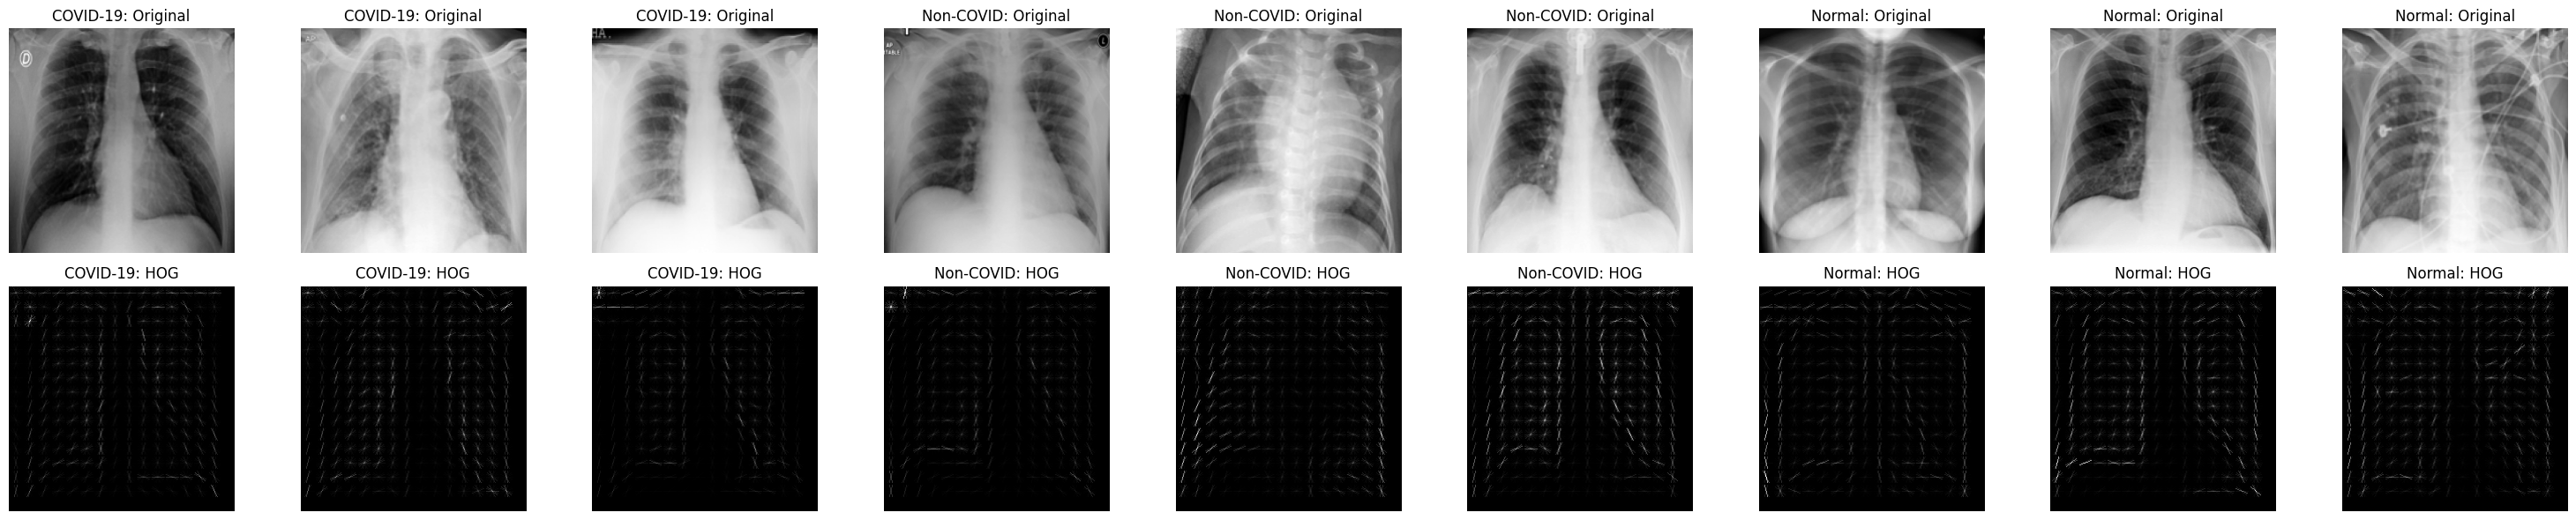

In [ ]:
# @title Vis: Original image and HOG image
def visualize_hog_features(df, n_samples=2, export_path='reports/figures/hog_features_train.png', figsize=(12,5), random_state=42):
    """
    Visualize the original images and HOG features of sample images.

    Parameters:
    - df_original: DataFrame containing the original images.
    - df_hog: DataFrame containing the HOG features.
    - n_samples: Number of sample images to visualize.
    """
    # Group by 'diag' and sample n_samples from each group
    df = df.groupby('diag').apply(lambda x: x.sample(n=n_samples, random_state=random_state)).reset_index(drop=True)

    # Visualize the original images and HOG features in two separate rows
    num_classes = df['diag'].nunique()
    fig, axes = plt.subplots(2, num_classes * n_samples, figsize=figsize)

    for i, (index, row) in enumerate(df.iterrows()):
        col = i % (num_classes * n_samples)
        axes[0, col].imshow(row['image_processed'], cmap='gray')
        axes[0, col].set_title(f"{row['diag']}")
        axes[0, col].axis('off')

        axes[1, col].imshow(row['hog_image'], cmap='gray')
        axes[1, col].set_title(f"{row['diag']}: HOG")
        axes[1, col].axis('off')

    plt.tight_layout()
    if export_path:
      plt.savefig(export_path)
    plt.show()

visualize_hog_features(df_hog_train, random_state=4)

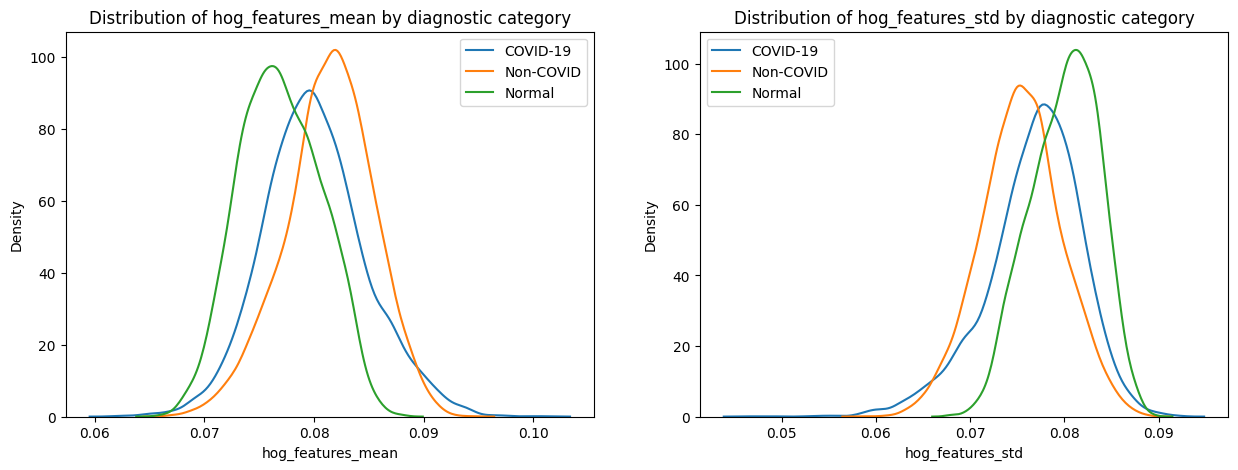

In [ ]:
# @title Vis: KDE Plot of HOG mean and std
def plot_hog_summary_statistics(df, export_path):
    """Plots distribution of mean and standard deviation of HOG features by diagnostic category."""
    # Copy the dataframe to avoid modifying the original
    df = df.copy()

    # Reduce each row of hog_features to a single value using mean and std
    df['hog_features_mean'] = df['hog_features'].apply(lambda x: np.mean(x))
    df['hog_features_std'] = df['hog_features'].apply(lambda x: np.std(x))

    # Plot the distribution of hog_features_mean and hog_features_std using density plot for each diagnostic category
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    for i, feature_name in enumerate(['hog_features_mean', 'hog_features_std']):
        for category in df['diag'].unique():
            sns.kdeplot(df[df['diag'] == category][feature_name], label=category, ax=axes[i])
        axes[i].set_title(f'Distribution of {feature_name} by diagnostic category')
        axes[i].set_xlabel(feature_name)
        axes[i].legend()

    # Export images
    plt.savefig(export_path)
    plt.show()

plot_hog_summary_statistics(df_hog_train, 'reports/figures/hog_feature_stats_train.png')

In [ ]:
def tsne_visualization(df, feature_col, n_components=2, random_seed=42, export_path=None):
    """
    Performs t-SNE on the specified features and visualizes the result, coloring by 'diag'.
    Supports both 2D and 3D visualizations.

    Parameters:
    - df: DataFrame containing features and 'diag'.
    - feature_col: Name of the column containing the features to visualize.
    - n_components: Number of dimensions for t-SNE (2 for 2D, 3 for 3D). Defaults to 2.
    - random_seed: Seed for random state in t-SNE.
    - export_path: Path to save the visualization. If None, no export is performed.
    """
    # Convert the list of features in each row into a suitable format for t-SNE
    features = np.array(df[feature_col].tolist()).astype(np.float32)

    # Perform t-SNE
    tsne = TSNE(n_components=n_components, random_state=random_seed)
    tsne_results = tsne.fit_transform(features)

    # Prepare for visualization
    tsne_col_names = [f'TSNE{i+1}' for i in range(n_components)]
    df_tsne = pd.DataFrame(tsne_results, columns=tsne_col_names)
    df_tsne['diag'] = df['diag'].values

    # Visualization
    if n_components == 3:
        fig = plt.figure(figsize=(15, 10))
        ax = fig.add_subplot(111, projection='3d')
        ax.set_xlabel('TSNE1')
        ax.set_ylabel('TSNE2')
        ax.set_zlabel('TSNE3')
    else:  # For 2D visualization
        fig, ax = plt.subplots(figsize=(15, 10))
        ax.set_xlabel('TSNE1')
        ax.set_ylabel('TSNE2')

    # Get unique labels for coloring
    labels = df['diag'].unique()

    # Plot each group
    for label in labels:
        indices = df_tsne['diag'] == label
        if n_components == 3:
            ax.scatter(df_tsne.loc[indices, 'TSNE1'], df_tsne.loc[indices, 'TSNE2'], df_tsne.loc[indices, 'TSNE3'], label=label)
        else:
            ax.scatter(df_tsne.loc[indices, 'TSNE1'], df_tsne.loc[indices, 'TSNE2'], label=label)

    ax.legend()
    plt.title(f't-SNE visualization of {feature_col} - {n_components}D')
    plt.show()

    # Export images
    if export_path:
      plt.savefig(export_path)

# tsne_visualization(
#     df=df_hog_train,
#     feature_col='hog_features',
#     export_path='reports/figures/tsne_hog_train.png'
#     )

## Pyradiomics
Here we calculate radiomics features based on original unprocessed data as pyradiomics does its own processing, and the preprocessed images are incompatible. Radiomics is insensitive to orientation or croppint as it is largely about extracting textural features in the masked regions.

We also perform some feature selection in which features that have very low correlation with the classes in the training data are removed from the full dataset.

The features we're extracting here are:

* Gray Level Co-occurrence Matrix (GLCM): GLCM characterizes the texture of an image by assessing the frequency pairs of pixel intensities, which is pivotal in differentiating structural patterns between normal and pneumonia-affected lung tissues.
* Gray Level Size Zone Matrix (GLSZM): GLSZM quantifies areas of similar pixel intensity in an image, essential for identifying variations in lung tissue density and size that distinguish between healthy, COVID pneumonia, and non-COVID pneumonia cases.
* Gray Level Run Length Matrix (GLRLM): GLRLM measures sequences of consecutive pixels having the same intensity value, aiding in the recognition of linear patterns that can vary between different lung conditions.
* Neighbouring Gray Tone Difference Matrix (NGTDM): NGTDM captures the texture smoothness by calculating the difference in intensity between a pixel and its neighbors, useful for identifying subtle changes in lung texture associated with early signs of pneumonia.
* Gray Level Dependence Matrix (GLDM): GLDM evaluates dependencies of pixel intensities at specific distances, facilitating the detection of abnormal tissue dependencies indicative of various pneumonia types.

We will follow this workflow:

1. Initial Feature Extraction (Subset-Training Only)
  * Filter for 'split' == 'train'.
  * Extract broad radiomics features (first-order, GLCM, GLSZM, GLRLM, NGTDM, GLDM) using relevant transformations (wavelet, LoG, gradient, original, LBP2D) with default hyperparameters.

4. Hyperparameter Tuning with Optuna (Subset-Training Only)
  * Target hyperparameters of selected features.
  * Design Optuna objectives to maximize average MI.

2. Pre-filter features (Full Training Only)
  * Take top mutual information score features
  * Remove highly correlated features
  * Iterate until desired number of features is selected

6. Feature Extraction (Full Dataset)
  * Filter full training df to selected columns
  * Extract radiomics features for val and test using selected columns

### Initial Feature Extraction

In [ ]:
# @title Helper Functions
def get_available_image_types():
  extractor = featureextractor.RadiomicsFeatureExtractor()
  extractor.enableAllImageTypes()
  return list(extractor.enabledImagetypes.keys())

# @title Extract with original, gradient, LBP2D, wavelet
def extract_radiomics_features(df,
                               img_col='image_normalized',
                               mask_col='mask_original',
                               image_types=['Original', 'Gradient', 'LBP2D', 'Wavelet'],
                               feature_names=['firstorder', 'glcm', 'glszm', 'glrlm', 'ngtdm', 'gldm'],
                               settings={},
                               include_diagnostics=False,
                               base_outfile_path=RADIOMICS_PATH,
                               suffix='_full',
                               force_run=False):
    """
    Extract radiomics features from images using PyRadiomics, dynamically generating output paths based on dataset type.

    Parameters:
    - df (pd.DataFrame): DataFrame containing the images and masks.
    - data_type (str): Segment of the dataset ('train', 'val', 'test') being processed.
    - img_col (str): Column in `df` containing the images.
    - mask_col (str): Column in `df` containing the masks.
    - image_types (list): Image types to extract features for.
    - feature_names (list): Feature names to extract.
    - settings (dict): Settings for the PyRadiomics library.
    - include_diagnostics (bool): Whether to include diagnostic columns.
    - base_outfile_path (str): Base path for output files, dynamically adjusted based on `data_type`.
    - force_run (bool): If True, features are extracted even if the output file exists.

    Returns:
    - DataFrame containing the extracted radiomics features. If `include_diagnostics` is True, returns a tuple of two
      DataFrames: the features and the diagnostics.
    """
    # Dynamically generate outfile paths
    outfile_path = f"{base_outfile_path}_{suffix}.pkl"
    diag_outfile_path = f"{base_outfile_path}_DIAG_{suffix}.pkl" if include_diagnostics else None

    if not force_run and os.path.exists(outfile_path):
        if include_diagnostics and os.path.exists(outfile_path) and os.path.exists(diag_outfile_path):
            print(f"Loading radiomics_df from: {outfile_path}")
            radiomics_df = pd.read_pickle(outfile_path)
            print(f"Loading radiomics_diag_df from: {diag_outfile_path}")
            radiomics_diag_df = pd.read_pickle(diag_outfile_path)
            return radiomics_df, radiomics_diag_df
        elif os.path.exists(outfile_path):
            print(f"Loading radiomics_df from: {outfile_path}")
            radiomics_df = pd.read_pickle(outfile_path)
            return radiomics_df

    else:
      print(f"{outfile_path} not found. Running radiomics feature extraction...")
      # Setup extractor with settings, image types, and feature classes.
      extractor = featureextractor.RadiomicsFeatureExtractor(**settings)
      for it in image_types:
        extractor.enableImageTypeByName(it)
      extractor.disableAllFeatures()
      for fn in feature_names:
        extractor.enableFeatureClassByName(fn)

      # Extract radiomics data
      images = df[img_col].to_list()
      masks = df[mask_col].to_list()

      results = Parallel(n_jobs=-1)(
          delayed(extractor.execute)(sitk.GetImageFromArray(im), sitk.GetImageFromArray(ms))
          for im, ms in zip(images, masks)
      )

      # Convert the results to a DataFrame
      radiomics_df = pd.DataFrame(results)

      # Define diagnostics columns
      diag_cols = [col for col in radiomics_df.columns if col.startswith('diagnostics')]

      # Get diagnostics columns
      if include_diagnostics:
        radiomics_diag_df = radiomics_df[diag_cols]

      # Drop unnecessary columns
      radiomics_df = radiomics_df.drop(columns=diag_cols)

      # Concatenate ['diag'] and handle infinite values
      initial_cols = ['filename', 'diag']
      radiomics_df = pd.concat([df[initial_cols].reset_index(drop=True), radiomics_df], axis=1)
      radiomics_df = radiomics_df.replace([np.inf, -np.inf], np.nan)

      # Drop columns with all NaN values
      num_cols_before = radiomics_df.shape[1]
      radiomics_df = radiomics_df.dropna(axis=1, how='all')
      num_cols_after = radiomics_df.shape[1]
      print(f"Number of columns dropped due to having infinite values: {num_cols_before - num_cols_after}")

      if base_outfile_path is not None:
        if include_diagnostics:
            pd.to_pickle(radiomics_df, outfile_path)
            print(f"Saved radiomics_df to: {outfile_path}")
            pd.to_pickle(radiomics_diag_df, diag_outfile_path)
            print(f"Saved radiomics_diag_df to: {diag_outfile_path}")
        else:
            pd.to_pickle(radiomics_df, outfile_path)
            print(f"Saved radiomics_df to: {outfile_path}")

      if include_diagnostics:
        return radiomics_df, radiomics_diag_df
      else:
        return radiomics_df

def calculate_mi_scores_from_settings(df, img_col, mask_col, image_types, feature_names, settings, class_col):
    """
    Extracts radiomics features with the provided settings and calculates the sum of MI scores.

    Parameters:
    - df: DataFrame containing the images and masks.
    - img_col: Name of the column containing the images.
    - mask_col: Name of the column containing the masks.
    - image_types: List of image types to extract features for.
    - feature_names: List of feature names to extract.
    - settings: Dictionary of settings for the PyRadiomics library.
    - class_col: Name of the column containing the class labels.

    Returns:
    - mi_score: Sum of MI scores extracted from the radiomics features.
    """
    radiomics_df = extract_radiomics_features(df, img_col, mask_col, image_types=image_types, feature_names=feature_names, settings=settings)
    feature_cols = [col for col in radiomics_df.columns if col != class_col]
    mi_score = mutual_info_classif(radiomics_df[feature_cols], radiomics_df[class_col], discrete_features='auto').sum()

    return mi_score

def compare_mi_radiomics(df, col_1, col_2, suffix_1, suffix_2, settings_1={}, settings_2={}, target_col='diag'):
    """
    Compares the mean mutual information (MI) scores of radiomics features extracted
    from two different image processing methods stored in a DataFrame.

    Parameters:
    - df: DataFrame containing the image data.
    - col_1, col_2: Column names for the two sets of images to compare.
    - suffix_1, suffix_2: Suffixes for the names of the dataframes
    - target_col: Name of the target variable column.

    Returns:
    - Tuple of mean mutual information scores for the two image types.
    """
    # Extract radiomics features
    radiomics_df_1 = extract_radiomics_features(df=df, suffix=suffix_1, img_col=col_1, settings=settings_1, mask_col='mask_original')
    radiomics_df_2 = extract_radiomics_features(df=df, suffix=suffix_2, img_col=col_2, settings=settings_2, mask_col='mask_original')

    # Calculate the mean mutual information score for each set of features
    feature_cols_1 = [col for col in radiomics_df_1.columns if col != target_col and col != 'filename']
    feature_cols_2 = [col for col in radiomics_df_2.columns if col != target_col and col != 'filename']

    mi_score_1 = mutual_info_classif(radiomics_df_1[feature_cols_1], df[target_col], discrete_features='auto').mean()
    mi_score_2 = mutual_info_classif(radiomics_df_2[feature_cols_2], df[target_col], discrete_features='auto').mean()

    print(f"MI score for {suffix_1}: {mi_score_1}")
    print(f"MI score for {suffix_2}: {mi_score_2}")

    return mi_score_1, mi_score_2

get_available_image_types()

INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}


['Original',
 'Exponential',
 'Gradient',
 'LBP2D',
 'LBP3D',
 'LoG',
 'Logarithm',
 'Square',
 'SquareRoot',
 'Wavelet']

In [ ]:
# @title Extract without CLAHE
radiomics_df_subset_train = extract_radiomics_features(df=df, suffix='subset_train', img_col='image_normalized', mask_col='mask_original', force_run=False)

Loading radiomics_df from: data/interim/RADIOMICS/RADIOMICS_features_subset_train.pkl


### Profile mutual information of extracted features

In [ ]:
def calculate_MI_scores(radiomics_df, class_col='diag', export_path=None, force_run=False):
    """
    Calculates mutual information (MI) scores between each radiomics feature and the class label.
    Tries loading the DataFrame from an export path, or runs the code and exports it if specified.

    Args:
        radiomics_df (pandas.DataFrame): DataFrame containing radiomics features and the class label.
        class_col (str): Name of the column within 'radiomics_df' containing the class label.
        export_path (str, optional): Path to export the MI scores DataFrame to. If the file exists,
            and force_run is False, it will attempt to load from this path.
        force_run (bool, optional): If True, forces the calculation of MI scores even if the export
            file exists. Defaults to False.

    Returns:
        pandas.DataFrame: DataFrame with 'features' as the index and their corresponding MI scores
        in the 'MI_score' column.
    """
    if export_path is not None and os.path.exists(export_path) and not force_run:
        print(f"Loading MI scores DataFrame from: {export_path}")
        return pd.read_pickle(export_path)

    # Proceed with MI score calculation if file does not exist or force_run is True
    feature_cols = radiomics_df.columns.difference([class_col, 'filename'])
    mi_scores = mutual_info_classif(radiomics_df[feature_cols], radiomics_df[class_col], discrete_features='auto')
    df_mi_scores = pd.DataFrame({'MI_score': mi_scores}, index=feature_cols).reset_index().rename(columns={'index': 'features'})

    # Additional processing
    df_mi_scores[['feature_transform', 'feature_class', 'feature_name']] = df_mi_scores['features'].str.split('_', n=2, expand=True)
    df_mi_scores['feature_transform_simple'] = df_mi_scores['feature_transform'].where(~df_mi_scores['feature_transform'].str.contains('wavelet'), 'wavelet')
    df_mi_scores = df_mi_scores[['features', 'feature_transform', 'feature_transform_simple', 'feature_class', 'feature_name', 'MI_score']]

    # Export DataFrame if export_path is provided
    if export_path is not None:
        df_mi_scores.to_pickle(export_path)
        print(f"Exported MI scores DataFrame to: {export_path}")

    return df_mi_scores

df_radiomics_subset_train_mi = calculate_MI_scores(radiomics_df=radiomics_df_subset_train, export_path=f'{RADIOMICS_PATH}_subset_train_mi.pkl', force_run=False)
dr_radiomics_subset_train_mi.head()

Loading MI scores DataFrame from: data/interim/RADIOMICS/RADIOMICS_features_subset_train_mi.pkl


features feature_transform  \
0          gradient_firstorder_10Percentile          gradient   
1          gradient_firstorder_90Percentile          gradient   
2                gradient_firstorder_Energy          gradient   
3               gradient_firstorder_Entropy          gradient   
4    gradient_firstorder_InterquartileRange          gradient   
..                                      ...               ...   
646               wavelet-LL_ngtdm_Busyness        wavelet-LL   
647             wavelet-LL_ngtdm_Coarseness        wavelet-LL   
648             wavelet-LL_ngtdm_Complexity        wavelet-LL   
649               wavelet-LL_ngtdm_Contrast        wavelet-LL   
650               wavelet-LL_ngtdm_Strength        wavelet-LL   

    feature_transform_simple feature_class        feature_name  MI_score  
0                   gradient    firstorder        10Percentile  0.028137  
1                   gradient    firstorder        90Percentile  0.068474  
2                   gradient    firstorder              Energy  0.075725  
3                   gradient    firstorder             Entropy  0.075908  
4                   gradient    firstorder  InterquartileRange  0.078070  
..                       ...           ...                 ...       ...  
646                  wavelet         ngtdm            Busyness  0.048179  
647                  wavelet         ngtdm          Coarseness  0.040013  
648                  wavelet         ngtdm          Complexity  0.087772  
649                  wavelet         ngtdm            Contrast  0.030352  
650                  wavelet         ngtdm            Strength  0.022395  

[651 rows x 6 columns]

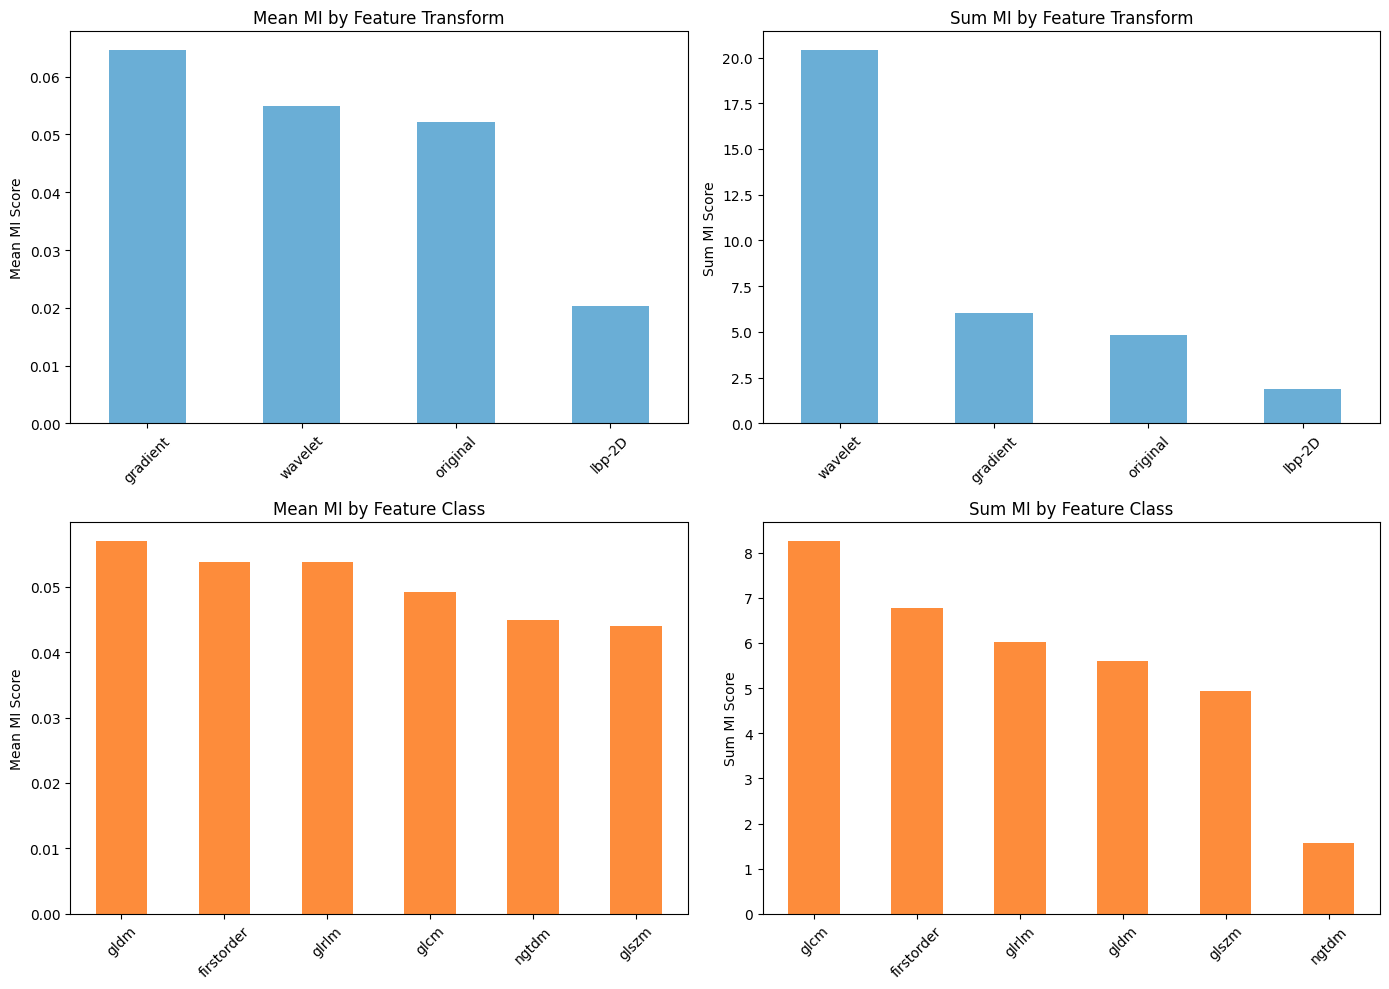

Figure saved to: reports/figures/MI_summary_bar_plots.png


<Figure size 640x480 with 0 Axes>

In [ ]:
# @title Vis: Mean and sum of MI scores by class and transform
def make_summary_bar_plots(df, figsize=(14,10), export_path='reports/figures/MI_summary_bar_plots.png'):
  """
  Creates bar plots for the mean and sum of MI scores for each feature class and feature transform.

  Args:
      df (pandas.DataFrame): DataFrame containing the MI scores.
      figsize (tuple, optional): Figure size in inches. Defaults to (14,10).
      export_path (str, optional): Path to save the figure. Defaults to 'reports/figures/MI_summary_bar_plots.png'.

  Returns:
      None
  """
  # Step 1: Aggregate the data
  agg_funcs = {'MI_score': ['mean', 'sum']}
  agg_transform_simple = df.groupby('feature_transform_simple').agg(agg_funcs).reset_index()
  agg_transform_simple.columns = ['feature_transform_simple', 'Mean_MI', 'Sum_MI']
  agg_feature_class = df.groupby('feature_class').agg(agg_funcs).reset_index()
  agg_feature_class.columns = ['feature_class', 'Mean_MI', 'Sum_MI']

  # Assuming the aggregated DataFrames are already created and named as follows:
  # agg_transform_simple and agg_feature_class

  # Sort the aggregated DataFrames
  agg_transform_simple_mean_sorted = agg_transform_simple.sort_values(by='Mean_MI', ascending=False)
  agg_transform_simple_sum_sorted = agg_transform_simple.sort_values(by='Sum_MI', ascending=False)
  agg_feature_class_mean_sorted = agg_feature_class.sort_values(by='Mean_MI', ascending=False)
  agg_feature_class_sum_sorted = agg_feature_class.sort_values(by='Sum_MI', ascending=False)

  # Define colors for each plot
  colors_class = sns.color_palette('Oranges', n_colors=1)
  colors_transform = sns.color_palette('Blues', n_colors=1)

  # Create 2x2 subplots
  fig, axs = plt.subplots(2, 2, figsize=figsize)

  # Plot with custom colors and sorted data
  # Top Left: Mean MI by Feature Transform Simple
  agg_transform_simple_mean_sorted.plot(x='feature_transform_simple', y='Mean_MI', kind='bar', ax=axs[0, 0], title='Mean MI by Feature Transform', legend=False, color=colors_transform)
  axs[0, 0].set_ylabel('Mean MI Score')
  axs[0, 0].set_xlabel('Transformation')

  # Top Right: Sum MI by Feature Transform Simple
  agg_transform_simple_sum_sorted.plot(x='feature_transform_simple', y='Sum_MI', kind='bar', ax=axs[0, 1], title='Sum MI by Feature Transform', legend=False, color=colors_transform)
  axs[0, 1].set_ylabel('Sum MI Score')
  axs[0, 1].set_xlabel('Transformation')

  # Bottom Left: Mean MI by Feature Class
  agg_feature_class_mean_sorted.plot(x='feature_class', y='Mean_MI', kind='bar', ax=axs[1, 0], title='Mean MI by Feature Class', legend=False, color=colors_class)
  axs[1, 0].set_ylabel('Mean MI Score')
  axs[1, 0].set_xlabel('Class')

  # Bottom Right: Sum MI by Feature Class
  agg_feature_class_sum_sorted.plot(x='feature_class', y='Sum_MI', kind='bar', ax=axs[1, 1], title='Sum MI by Feature Class', legend=False, color=colors_class)
  axs[1, 1].set_ylabel('Sum MI Score')
  axs[1, 1].set_xlabel('Class')

  # Set x-axis labels rotation and remove x-axis label
  for ax in axs.flatten():
      ax.tick_params(axis='x', rotation=45)
      ax.set_xlabel('')

  # Adjust layout and display
  plt.tight_layout()
  plt.show()

  # Export the figure if export_path is provided
  if export_path:
    plt.savefig(export_path)
    print(f"Figure saved to: {export_path}")

make_summary_bar_plots(df_radiomics_subset_train_mi)

Text(0.5, 1.0, 'Feature Class')

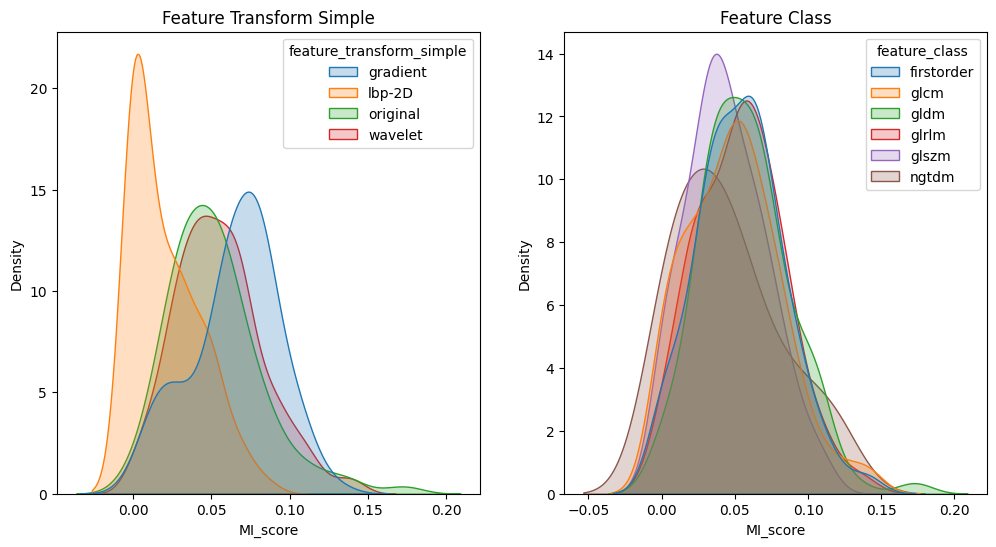

In [ ]:
# @title Vis: Density plot of MI
def radiomics_MI_density_plot(df=df_radiomics_subset_train_mi, export_path='reports/figures/radiomics_mi_density_plot.png'):
  # Create two subplots side by side
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

  # Plot density plot colored by feature_transform_simple
  sns.kdeplot(data=df, x="MI_score", hue="feature_transform_simple", fill=True, common_norm=False, ax=ax1)
  ax1.set_title("Feature Transform Simple")
  ax1.set_xlabel("MI Score")

  # Plot density plot colored by feature_class
  sns.kdeplot(data=df, x="MI_score", hue="feature_class", fill=True, common_norm=False, ax=ax2)
  ax2.set_title("Feature Class")
  ax2.set_xlabel("MI Score")

  # Adjust layout and display
  plt.tight_layout()
  plt.show()

  # Export the figure if export_path is provided
  if export_path:
    plt.savefig(export_path)

radiomics_MI_density_plot

In [ ]:
# @title Summary statistics for MI scores
def summarize_MI_scores(df):
    """
    Summarizes the MI scores for each feature class and feature transform.
    """
    df_summary_class = df.groupby(['feature_class']).agg({'MI_score': ['mean', 'sum', 'count']})
    df_summary_class = df_summary_class.sort_values(by=('MI_score', 'sum'), ascending=False)
    df_summary_transform = df.groupby(['feature_transform_simple']).agg({'MI_score': ['mean', 'sum', 'count']})
    df_summary_transform = df_summary_transform.sort_values(by=('MI_score', 'sum'), ascending=False)
    return df_summary_class, df_summary_transform

df_mi_class_stats, df_mi_transform_stats = summarize_MI_scores(df_radiomics_subset_train_mi)
display(df_mi_class_stats)
display(df_mi_transform_stats)

MI_score                
                   mean       sum count
feature_class                          
glcm           0.049212  8.267690   168
firstorder     0.053822  6.781601   126
glrlm          0.053723  6.016940   112
gldm           0.057043  5.590176    98
glszm          0.044041  4.932570   112
ngtdm          0.044957  1.573501    35

MI_score                 
                              mean        sum count
feature_transform_simple                           
wavelet                   0.054873  20.412604   372
gradient                  0.064618   6.009439    93
original                  0.052182   4.852886    93
lbp-2D                    0.020296   1.887548    93

Exported heatmap to: reports/figures/radiomics_mi_heatmaps.png


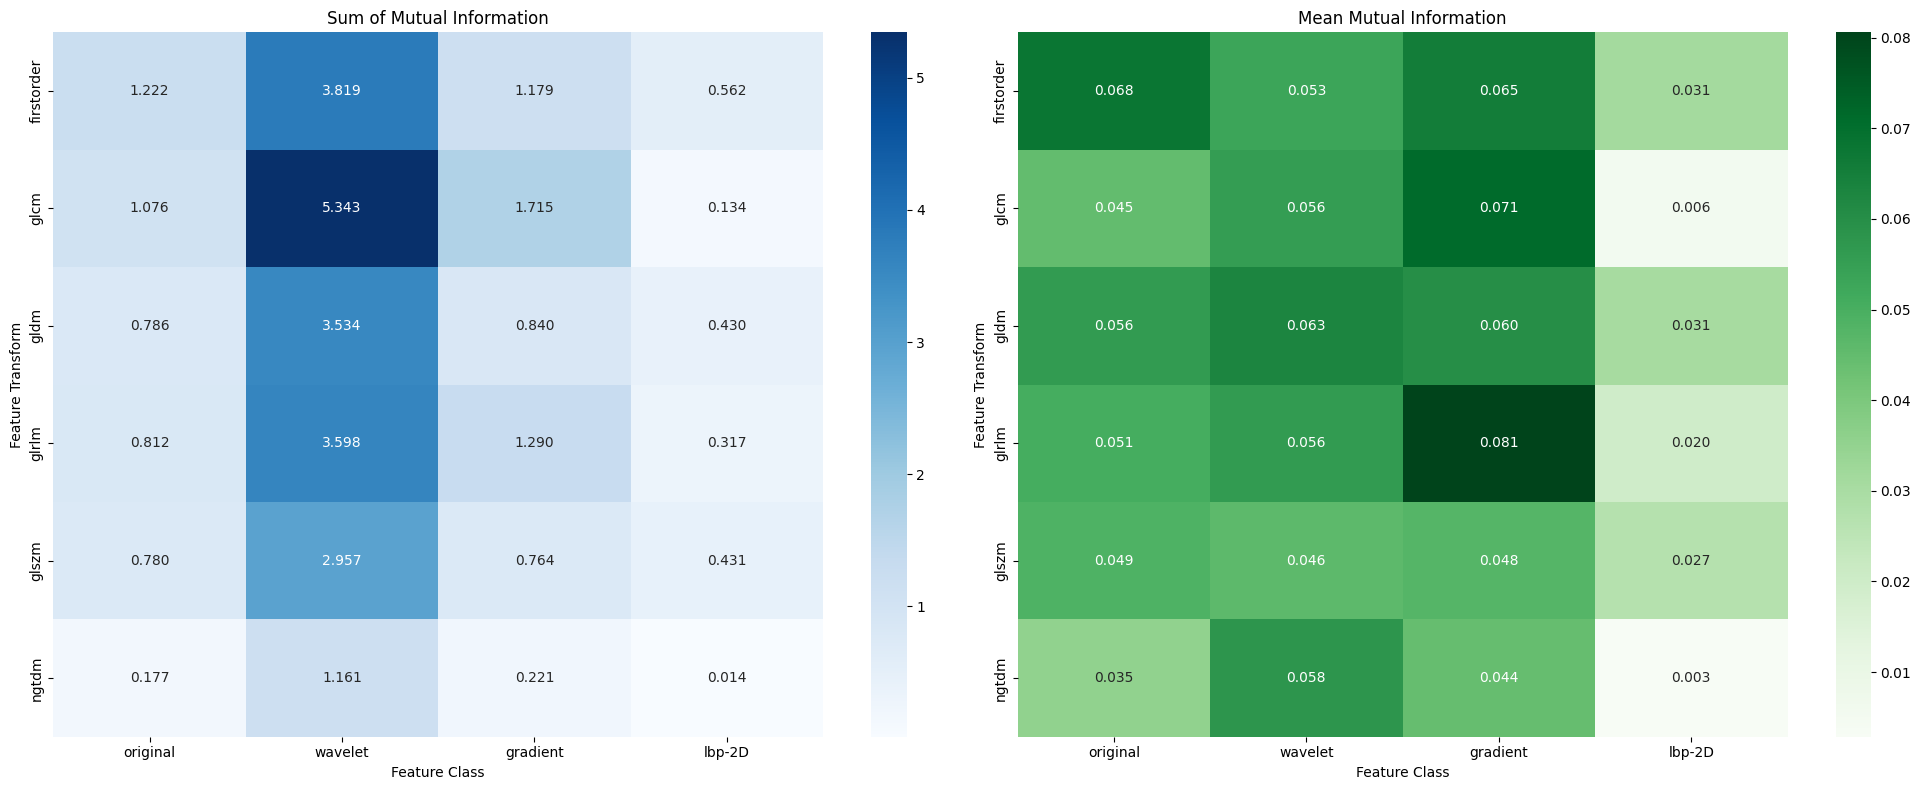

In [ ]:
# @title Vis: Heatmap of mean and sum of MI
def create_MI_pivot_tables(df):
  """
  Creates pivot tables for the mean, sum, and count of MI scores for each feature class and feature transform.

  Args:
      df (pandas.DataFrame): DataFrame containing the MI scores.

  Returns:
      pivot_count (pandas.DataFrame): Pivot table for the count of MI scores.
      pivot_sum (pandas.DataFrame): Pivot table for the sum of MI scores.
      pivot_mean (pandas.DataFrame): Pivot table for the mean of MI scores.
  """
  pivot_count = df.pivot_table(values='MI_score', index='feature_class',
                              columns='feature_transform_simple', aggfunc='count', margins=False, fill_value=0)

  pivot_sum = df.pivot_table(values='MI_score', index='feature_class',
                            columns='feature_transform_simple', aggfunc='sum', margins=False, fill_value=0)

  pivot_mean = df.pivot_table(values='MI_score', index='feature_class',
                              columns='feature_transform_simple', aggfunc='mean', margins=False, fill_value=0)

  desired_order = ['original', 'wavelet', 'gradient', 'lbp-2D']
  pivot_count = pivot_count.reindex(columns=desired_order)
  pivot_sum = pivot_sum.reindex(columns=desired_order)
  pivot_mean = pivot_mean.reindex(columns=desired_order)

  return pivot_count, pivot_sum, pivot_mean

def plot_two_heatmaps_side_by_side(pivot1, title1, pivot2, title2, xlabel='Feature Class', ylabel='Feature Transform', figsize=(20, 8), export_path='reports/figures/radiomics_mi_heatmaps.png'):
  """
  Plots two heatmaps side by side.

  Args:
      pivot1 (pandas.DataFrame): Pivot table for the first heatmap.
      title1 (str): Title for the first heatmap.
      pivot2 (pandas.DataFrame): Pivot table for the second heatmap.
      title2 (str): Title for the second heatmap.
      xlabel (str): Label for the x-axis.
      ylabel (str): Label for the y-axis.
      figsize (tuple, optional): Figure size in inches. Defaults to (20, 8).

  Returns:
      fig (matplotlib.figure.Figure): Matplotlib figure object.
  """
  def _create_heatmap_from_pivot_table(pivot_table, title, ax, figsize=(10,8), fmt='.3f', cmap='Blues'):
    """
    Creates a heatmap from a pivot table.

    Args:
        pivot_table (pandas.DataFrame): Pivot table to create the heatmap from.
        title (str): Title for the heatmap.
        ax (matplotlib.axes._subplots.AxesSubplot): Matplotlib axes object.
        figsize (tuple, optional): Figure size in inches. Defaults to (10, 8).
        fmt (str, optional): Format string for the heatmap values. Defaults to '.3f'.
        cmap (str, optional): Color map for the heatmap. Defaults to 'Blues'.
    """
    sns.heatmap(pivot_table, annot=True, fmt=fmt, cmap=cmap, ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Feature Class')
    ax.set_ylabel('Feature Transform')

  fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=figsize)

  _create_heatmap_from_pivot_table(pivot1, title1, ax=ax1, cmap='Blues')
  _create_heatmap_from_pivot_table(pivot2, title2, ax=ax2, cmap='Greens')

  plt.tight_layout()

  if export_path:
    fig.savefig(export_path, dpi=300)
    print(f"Exported heatmap to: {export_path}")

  return fig

pivot_count, pivot_sum, pivot_mean = create_MI_pivot_tables(df_radiomics_subset_train_mi)
radiomics_mi_heatmaps = plot_two_heatmaps_side_by_side(pivot_sum, 'Sum of Mutual Information', pivot_mean, 'Mean Mutual Information')

Based on the above it appears that hyperparameter tuning should focus on the following:

**Sampling**
- Because the region of interests of images vary and pyradiomics is sensitive to these

**Transformations**
- Gradient (on average, the individual features have the highest MI scores)
- Wavelet (large number of features, second highest average MI scores)

**Feature Classes**
- GLCM (highest total MI score)
- GLRLM (second highest total MI score)
- GLDM (third highest total MI score)

To save compute, we will do this sequentially:
1. Determine optimal sampling strategy
2. Determine optimal gradient settings, given the optimal sampling strategy
3. Determine optimal wavelet settings, given the optimal sampling strategy
4. Determine optimal GLCM settings, given the optimal gradient/wavelet/sampling strategy
5. Determine optimal GLRLM settings, given the optimal gradient/wavelet/sampling strategy
6. Determine optimal GLDM settings, given the optimal gradient/wavelet/sampling strategy

### Hyperparameter tuning

In [ ]:
# Note that the df_subset_train is still too large so we will further subset this for some experiments
df_subset_train_s = df_subset_train.sample(frac=0.1, random_state=42)

# Reset index
df_subset_train_s = df_subset_train_s.reset_index(drop=True)

df_subset_train_s['diag'].value_counts()

diag
Normal       76
COVID-19     68
Non-COVID    62
Name: count, dtype: int64

In [ ]:
# @title Helper code
def find_best_radiomics_params(objective_func, df, df_args, n_trials=20, force_run=False,
                               study_folder_path=RADIOMICS_STUDY_PATH, study_name=None):
    """
    Finds the best parameters using Optuna.

    Args:
        objective_func (callable): The objective function to optimize.
        df (pandas.DataFrame): DataFrame containing the dataset.
        df_args (list): List of additional arguments to pass to objective_func (e.g., column names).
        n_trials (int): Number of trials for the Optuna study.
        force_run (bool): If True, forces the optimization to run even if a study file exists.
        study_folder_path (str): Path to the folder where the study file is saved.
        study_name (str): Name of the Optuna study. If None, the objective function's name is used.

    Returns:
        optuna.study.Study: The Optuna study object with the optimization results.
    """

    if study_name is None:
        study_name = objective_func.__name__

    study_file_path = os.path.join(study_folder_path, study_name)

    if os.path.exists(study_file_path) and not force_run:
        print("Loading existing study...")
        with open(study_file_path, 'rb') as f:
            study = pickle.load(f)
    else:
        study = optuna.create_study(direction='maximize', study_name=study_name, load_if_exists=True)
        study.optimize(lambda trial: objective_func(trial, df, *df_args), n_trials=n_trials)

        with open(study_file_path, 'wb') as f:
            pickle.dump(study, f)
        print("Study saved.")

    best_params = study.best_params
    print("Best parameters found: ", best_params, ". Best value found: ", study.best_value)

    return study

def calculate_mi_scores_from_settings(df, img_col, mask_col, image_types, feature_names, settings, class_col):
    """
    Extracts radiomics features with the provided settings and calculates the sum of MI scores.
    """
    def _extract_radiomics_features(df, img_col, mask_col, image_types, feature_names, settings):
      """
      Helper function to extract radiomics features from a DataFrame. Only used for hyperparameter tuning.
      """
      # Setup extractor with settings, image types, and feature classes.
      extractor = featureextractor.RadiomicsFeatureExtractor(**settings)
      for it in image_types:
        extractor.enableImageTypeByName(it)
      extractor.disableAllFeatures()
      for fn in feature_names:
        extractor.enableFeatureClassByName(fn)

      # Extract radiomics data
      images = df[img_col].to_list()
      masks = df[mask_col].to_list()

      results = Parallel(n_jobs=-1)(
          delayed(extractor.execute)(sitk.GetImageFromArray(im), sitk.GetImageFromArray(ms))
          for im, ms in zip(images, masks)
      )

      # Convert the results to a DataFrame
      radiomics_df = pd.DataFrame(results)

      # Drop unnecessary columns, columns with inf
      radiomics_df = radiomics_df.drop(columns=[col for col in radiomics_df.columns if col.startswith('diagnostics')])
      radiomics_df = radiomics_df.replace([np.inf, -np.inf], np.nan)
      radiomics_df = radiomics_df.dropna(axis=1, how='all')

      # Reset index
      radiomics_df = radiomics_df.reset_index(drop=True)

      return radiomics_df

    # Extract radiomics features
    print("Extracting radiomics features...")
    radiomics_df = _extract_radiomics_features(df, img_col, mask_col, image_types=image_types, feature_names=feature_names, settings=settings)

    # Calculate MI scores in parallel
    print("Calculating MI scores...")
    mi_scores = mutual_info_classif(radiomics_df, df[class_col], discrete_features='auto')

    return np.sum(mi_scores)

def print_study_results(study):
    """Prints out all study results"""
    for trial in study.trials:
        print(f"Trial {trial.number}:")
        print(f"  Value: {trial.value}")
        print(f"  Params: {trial.params}")

#### Sampling hyperparameters

First we test whether or not we need to do resampling at all

In [ ]:
def objective_sampling_binary(trial, df, img_col, mask_col, class_col):
    do_resample = trial.suggest_categorical('do_resample', ['True', 'False'])

    settings = {
        'do_resample': do_resample,
        'binWidth': trial.suggest_float('binWidth', 5, 20, step=5),
    }

    mi_scores = calculate_mi_scores_from_settings(df, img_col, mask_col,
                                                  image_types=['Wavelet', 'Gradient'], # Focus on just the key transformations
                                                  feature_names=['firstorder', 'glcm', 'glrlm', 'gldm'], # Focus on just the key feature classes
                                                  settings=settings,
                                                  class_col=class_col)

    return mi_scores

sampling_study_1 = find_best_radiomics_params(objective_sampling_binary,
                                              df_subset_train,
                                              ['image_normalized', 'mask_original', 'diag'],
                                              n_trials=10,
                                              force_run=False,
                                              study_name='radiomics_sampling_study_1')

Loading existing study...
Best parameters found:  {'do_resample': 'True', 'binWidth': 20.0} . Best value found:  26.419923196967225


It looks like there's minimal difference between do_resample = True and do_resample = False. We'll just find the best configuration for do_resample = False

In [ ]:
best_sampling_value = float('inf')  # Initialize with infinity or any large number
best_sampling_params = None

# Iterate through all completed trials in the study
for trial in sampling_study_1.trials:
    # Check if the trial was successful and meets the condition
    if trial.state == optuna.trial.TrialState.COMPLETE and trial.params['do_resample'] == 'False':
        # Update best trial information if the current trial has a better value
        if trial.value < best_sampling_value:  # Assuming you're minimizing; use > for maximizing
            best_sampling_value = trial.value
            best_sampling_params = trial.params

# Output the best trial parameters and value found with do_resample = False
if best_sampling_params is not None:
    print(f"Best trial with do_resample = False: Value = {best_sampling_value}, Parameters = {best_sampling_params}")
else:
    print("No completed trials found with do_resample = False.")

Best trial with do_resample = False: Value = 25.196753971745892, Parameters = {'do_resample': 'False', 'binWidth': 5.0}


#### Gradient Hyperparameters

In [ ]:
def objective_gradient(trial, df, img_col, mask_col, class_col, best_sampling_params):
    use_spacing = trial.suggest_categorical('gradientUseSpacing', [True, False])

    settings = {
        'do_resample': best_sampling_params['do_resample'],
        'binWidth': best_sampling_params['binWidth'],
        'gradientUseSpacing': use_spacing,
    }

    mi_scores = calculate_mi_scores_from_settings(df, img_col, mask_col,
                                                  image_types=['Gradient'], # Focus on Gradient
                                                  feature_names=['firstorder', 'glcm', 'glrlm', 'gldm'],
                                                  settings=settings,
                                                  class_col=class_col)

    return mi_scores

gradient_study = find_best_radiomics_params(objective_gradient,
                                            df_subset_train_s,
                                            ['image_normalized', 'mask_original', 'diag', best_sampling_params],
                                            n_trials=4,
                                            force_run=False,
                                            study_name='radiomics_gradient_study')

Loading existing study...
Best parameters found:  {'gradientUseSpacing': False} . Best value found:  7.798891027816476


#### Wavelet Hyperparameters

In [ ]:
def objective_wavelet_1(trial, df, img_col, mask_col, class_col, best_sampling_params):
    # Wavelet Settings
    # start_level = trial.suggest_int('start_level', 0, 1)
    # level = trial.suggest_int('level', 1, 3)
    wavelet_type = trial.suggest_categorical('wavelet', ['coif1', 'db1', 'sym2'])

    settings = {
        # Apply optimal sampling settings
        'do_resample': best_sampling_params['do_resample'],
        'binWidth': best_sampling_params['binWidth'],

        # # Wavelet-specific settings
        # 'start_level': start_level,
        # 'level': level,
        'wavelet': wavelet_type
    }

    # Calculate MI scores (reuse your logic)
    mi_scores = calculate_mi_scores_from_settings(df, img_col, mask_col,
                                                  image_types=['Wavelet'],  # Focus on Wavelet
                                                  feature_names=['firstorder', 'glcm', 'glrlm', 'gldm'],
                                                  settings=settings,
                                                  class_col=class_col)

    return mi_scores

wavelet_study_1 = find_best_radiomics_params(objective_wavelet_1,
                                           df_subset_train_s,
                                            ['image_normalized', 'mask_original', 'diag', best_sampling_params],
                                           n_trials=5,
                                           force_run=False,
                                           study_name='radiomics_wavelet_study_1')

Loading existing study...
Best parameters found:  {'wavelet': 'coif1'} . Best value found:  20.056210364893563


In [ ]:
# Print out all trials from wavelet_study_1
for trial in wavelet_study_1.trials:
    print(f"Trial {trial.number}: Value = {trial.value}, Parameters = {trial.params}")

Trial 0: Value = 18.62712698148173, Parameters = {'wavelet': 'sym2'}
Trial 1: Value = 18.868622354935567, Parameters = {'wavelet': 'db1'}
Trial 2: Value = 18.597588941341133, Parameters = {'wavelet': 'sym2'}
Trial 3: Value = 20.056210364893563, Parameters = {'wavelet': 'coif1'}
Trial 4: Value = 20.046906382037797, Parameters = {'wavelet': 'coif1'}


In [ ]:
def objective_wavelet_2(trial, df, img_col, mask_col, class_col, best_sampling_params):
    # Wavelet Settings
    start_level = trial.suggest_int('start_level', 0, 1)
    level = trial.suggest_int('level', 1, 3)
    wavelet_type = trial.suggest_categorical('wavelet', ['coif1', 'coif2', 'coif3'])

    settings = {
        # Apply optimal sampling settings
        'do_resample': best_sampling_params['do_resample'],
        'binWidth': best_sampling_params['binWidth'],

        # # Wavelet-specific settings
        'start_level': start_level,
        'level': level,
        'wavelet': wavelet_type
    }

    # Calculate MI scores (reuse your logic)
    mi_scores = calculate_mi_scores_from_settings(df, img_col, mask_col,
                                                  image_types=['Wavelet'],  # Focus on Wavelet
                                                  feature_names=['firstorder', 'glcm', 'glrlm', 'gldm'],
                                                  settings=settings,
                                                  class_col=class_col)

    return mi_scores

wavelet_study_2 = find_best_radiomics_params(objective_wavelet_2,
                                           df_subset_train_s,
                                            ['image_normalized', 'mask_original', 'diag', best_sampling_params],
                                           n_trials=20,
                                           force_run=False,
                                           study_name='radiomics_wavelet_study_2')

Loading existing study...
Best parameters found:  {'start_level': 1, 'level': 3, 'wavelet': 'coif1'} . Best value found:  41.45273705509136


#### GLCM Hyperparameters

In [ ]:
# def objective_glcm(trial, df, img_col, mask_col, class_col, best_sampling_params, best_gradient_params, best_wavelet_params):
#     # GLCM-specific hyperparameters to tune
#     glcm_symmetrical = trial.suggest_categorical('symmetrical', [True, False])
#     glcm_distance_value = trial.suggest_int('glcm_distance', 1, 3)
#     glcm_distances = [glcm_distance_value]
#     glcm_weightingNorm = trial.suggest_categorical('weightingNorm', ['euclidean', 'manhattan', 'none'])

#     settings = {
#         # Inherited optimal settings
#         'do_resample': best_sampling_params['do_resample'],
#         'binWidth': best_sampling_params['binWidth'],
#         'gradientUseSpacing': best_gradient_params['gradientUseSpacing'],
#         'start_level': best_wavelet_params['start_level'],
#         'level': best_wavelet_params['level'],
#         'wavelet': best_wavelet_params['wavelet'],

#         # GLCM-specific settings
#         'glcm_symmetrical': glcm_symmetrical,
#         'glcm_distance': glcm_distances,
#         'glcm_weightingNorm': glcm_weightingNorm
#     }

#     # Calculate MI scores focusing on GLCM
#     mi_scores = calculate_mi_scores_from_settings(df, img_col, mask_col,
#                                                   image_types=['Original', 'Wavelet', 'Gradient'],
#                                                   feature_names=['glcm'],  # Focus on GLCM
#                                                   settings=settings,
#                                                   class_col=class_col)

#     return mi_scores

# glcm_study = find_best_radiomics_params(objective_glcm,
#                                           df_subset_train_s,
#                                           ['image_normalized', 'mask_original', 'diag', best_sampling_params, gradient_study.best_params, wavelet_study_2.best_params],
#                                           n_trials=15,
#                                           force_run=False,
#                                           study_name='radiomics_glcm_study')

Note GLCM hyperparameters do not seem to impact mutual information, so we will just use defaults for GLCM. (I tested in a separate notebook just altering distance and the mutual information scores stay the same).

#### GLRLM Hyperparameters

In [ ]:
def objective_glrlm(trial, df, img_col, mask_col, class_col, best_sampling_params, best_gradient_params, best_wavelet_params):
    # GLRLM-specific hyperparameters to tune
    glrlm_weightingNorm = trial.suggest_categorical('weightingNorm', ['euclidean', 'manhattan', None])

    settings = {
        # Inherited optimal settings
        'do_resample': best_sampling_params['do_resample'],
        'binWidth': best_sampling_params['binWidth'],
        'gradientUseSpacing': best_gradient_params['gradientUseSpacing'],
        'start_level': best_wavelet_params['start_level'],
        'level': best_wavelet_params['level'],
        'wavelet': best_wavelet_params['wavelet'],

        # GLRLM-specific settings
        'weightingNorm': glrlm_weightingNorm,
    }

    # Calculate MI scores focusing on GLRLM
    mi_scores = calculate_mi_scores_from_settings(df, img_col, mask_col,
                                                  image_types=['Original', 'Wavelet', 'Gradient'],
                                                  feature_names=['glrlm'],  # Focus on GLRLM
                                                  settings=settings,
                                                  class_col=class_col)

    return mi_scores

glrlm_study = find_best_radiomics_params(objective_glrlm,
                                         df_subset_train_s,
                                        ['image_normalized', 'mask_original', 'diag', best_sampling_params, gradient_study.best_params, wavelet_study_2.best_params],
                                         n_trials=5,
                                         force_run=False,
                                         study_name='radiomics_glrlm_study')

Loading existing study...
Best parameters found:  {'weightingNorm': 'manhattan'} . Best value found:  8.930453527326177


#### GLDM Hyperparameters

Note: If GLCM comes up with optimal distance then this will need to inherit from there

In [ ]:
def objective_gldm(trial, df, img_col, mask_col, class_col, best_sampling_params, best_gradient_params, best_wavelet_params):
    # Adjusting GLDM-specific hyperparameters to tune
    gldm_distance_value = trial.suggest_int('gldm_distance', 1, 3)
    gldm_distances = [gldm_distance_value]
    gldm_alpha = trial.suggest_int('gldm_a', 0, 5)

    settings = {
        # Inherited optimal settings
        'do_resample': best_sampling_params['do_resample'],
        'binWidth': best_sampling_params['binWidth'],
        'gradientUseSpacing': best_gradient_params['gradientUseSpacing'],
        'start_level': best_wavelet_params['start_level'],
        'level': best_wavelet_params['level'],
        'wavelet': best_wavelet_params['wavelet'],

        # GLDM-specific settings
        'gldm_distance': gldm_distances,
        'gldm_a': gldm_alpha,
    }

    # Calculate MI scores focusing on GLDM
    mi_scores = calculate_mi_scores_from_settings(df, img_col, mask_col,
                                                  image_types=['Original', 'Wavelet', 'Gradient'],
                                                  feature_names=['gldm'],
                                                  settings=settings,
                                                  class_col=class_col)

    return mi_scores

gldm_study = find_best_radiomics_params(objective_gldm,
                                        df_subset_train_s,
                                        ['image_normalized', 'mask_original', 'diag', best_sampling_params, gradient_study.best_params, wavelet_study_2.best_params],
                                        n_trials=20,
                                        force_run=False,
                                        study_name='radiomics_gldm_study')

Loading existing study...
Best parameters found:  {'gldm_distance': 1, 'gldm_a': 1} . Best value found:  9.355284363062768


### Feature Extraction with Optimal Hyperparameters

In [ ]:
# @title Compile optimal radiomics settings
def compile_optimal_radiomics_settings(sampling_params, gradient_params, wavelet_params, glcm_params, glrlm_params, gldm_params):
  """
  Creates a dictionary of optimal radiomics settings.

  Parameters:
  - sampling_params (dict): Sampling parameters.
  - gradient_params (dict): Gradient parameters.
  - wavelet_params (dict): Wavelet parameters.
  - glcm_params (dict): GLCM parameters.
  - glrlm_params (dict): GLRLM parameters.
  - gldm_params (dict): GLDM parameters.

  Returns:
  - settings (dict): Dictionary of optimal radiomics settings.
  """
  settings = {}

  # List all parameter dictionaries
  params_list = [sampling_params, gradient_params, wavelet_params, glcm_params, glrlm_params, gldm_params]

  # Merge dictionaries, skipping any that are None
  for params in params_list:
      if params is not None:
          settings.update(params)

  # Replace 'gldm_distance' with 'distance'
  if 'gldm_distance' in settings:
      settings['distances'] = settings.pop('gldm_distance')
      settings['distances'] = [settings['distances']]
  else:
      settings['distances'] = [settings['distances']]

  return settings

def load_radiomics_settings(radiomics_settings_path=RADIOMICS_SETTINGS_PATH):
  """
  Loads radiomics settings from a file.

  Parameters:
  - radiomics_settings_path (str): Path to the radiomics settings file.

  Returns:
  - radiomics_settings (dict): Loaded radiomics settings.
  """
  try:
      with open(radiomics_settings_path, 'rb') as f:
          radiomics_settings = pickle.load(f)
          print("Radiomics settings loaded successfully.")
  except FileNotFoundError:
      print("Radiomics settings file not found. Running default settings...")
      radiomics_settings = compile_optimal_radiomics_settings(best_sampling_params, gradient_study.best_params, wavelet_study_2.best_params, None, glrlm_study.best_params, gldm_study.best_params)
      with open(radiomics_settings_path, 'wb') as f:
          pickle.dump(radiomics_settings, f)
          print("Radiomics settings saved successfully.")

  return radiomics_settings

radiomics_settings = load_radiomics_settings(RADIOMICS_SETTINGS_PATH)
pprint(radiomics_settings)

Radiomics settings loaded successfully.
{'binWidth': 5.0,
 'distances': [1],
 'do_resample': 'False',
 'gldm_a': 1,
 'gradientUseSpacing': False,
 'level': 3,
 'start_level': 1,
 'wavelet': 'coif1',
 'weightingNorm': 'manhattan'}


In [ ]:
# @title Extract radiomics features for full training dataset
def process_radiomics_in_batches(df, data_type, settings, image_types, feature_names, img_col='image_normalized', mask_col='mask_original', force_run=False, batch_size=50, base_outfile_path=RADIOMICS_PATH_FULL):
    """
    Processes radiomics features extraction in batches and displays progress.

    Parameters:
    - df (pd.DataFrame): DataFrame containing the images and masks to process.
    - data_type (str): Segment of the dataset ('train', 'val', 'test') being processed.
    - settings (dict): Settings for the PyRadiomics library.
    - image_types (list): Image types to extract features for.
    - feature_names (list): Feature names to extract.
    - img_col (str): Column name for images in `df`.
    - mask_col (str): Column name for masks in `df`.
    - force_run (bool): If True, features are extracted even if the output file exists.
    - batch_size (int): The size of each batch for processing.
    - base_outfile_path (str, optional): File path to export to.

    Returns:
    - pd.DataFrame: DataFrame containing all the extracted radiomics features.
    """

    def _split_dataframe_into_batches(df, batch_size):
        """Splits a DataFrame into batches of a specified size."""
        return [df[i:i + batch_size] for i in range(0, df.shape[0], batch_size)]

    def _extract_and_save_batch(batch, batch_index, data_type, settings, image_types, feature_names, img_col, mask_col, base_outfile_path):
        """Extracts radiomics features for a given batch and saves the results."""
        batch_subfolder_path = os.path.join(base_outfile_path, "batches")
        if not os.path.exists(batch_subfolder_path):
            os.makedirs(batch_subfolder_path)
        batch_outfile_path = os.path.join(batch_subfolder_path, f"{data_type}_radiomics_batch_{batch_index}.pkl")
        if not os.path.exists(batch_outfile_path) or force_run:
            batch_result = _extract_radiomics_features(batch, img_col, mask_col, image_types, feature_names, settings)
            joblib.dump(batch_result, batch_outfile_path)
            print(f"Batch {batch_index} results saved.")
        else:
            print(f"Batch {batch_index} already processed. Loading results...")
            batch_result = joblib.load(batch_outfile_path)
        return batch_result

    def _extract_radiomics_features(df, img_col, mask_col, image_types, feature_names, settings):
        """Extracts radiomics features from images using PyRadiomics."""
        logger = logging.getLogger("radiomics")
        logger.setLevel(logging.ERROR)

        extractor = featureextractor.RadiomicsFeatureExtractor(**settings)
        for it in image_types:
            extractor.enableImageTypeByName(it)
        extractor.disableAllFeatures()
        for fn in feature_names:
            extractor.enableFeatureClassByName(fn)

        results = []
        for index, row in df.iterrows():
            image = sitk.GetImageFromArray(row[img_col])
            mask = sitk.GetImageFromArray(row[mask_col])
            result = extractor.execute(image, mask)
            results.append(result)

        radiomics_df = pd.DataFrame(results)
        radiomics_df = pd.concat([df[['filename']].reset_index(drop=True), radiomics_df], axis=1)
        radiomics_df = radiomics_df.replace([np.inf, -np.inf], np.nan)
        radiomics_df = radiomics_df.dropna(axis=1, how='all')

        return radiomics_df

    outfile_path = f"{base_outfile_path}_{data_type}.pkl"

    if not os.path.exists(outfile_path) or force_run:
      print(f"{outfile_path} not found. Running extraction")

      batch_results = []
      batches = _split_dataframe_into_batches(df, batch_size)
      for batch_index, batch in enumerate(tqdm(batches, desc="Processing Batches")):
          batch_result = _extract_and_save_batch(batch, batch_index, data_type, settings, image_types, feature_names, img_col, mask_col, base_outfile_path)
          batch_results.append(batch_result)

      df_radiomics_complete = pd.concat(batch_results, ignore_index=True)
      df_radiomics_complete.to_pickle(outfile_path)
      print(f"Results saved to {outfile_path}")

    elif os.path.exists(outfile_path):
      print(f"{outfile_path} found. Loading results...")
      df_radiomics_complete = pd.read_pickle(outfile_path)

    return df_radiomics_complete

df_radiomics_train = process_radiomics_in_batches(
    df=df_train[['filename', 'diag', 'split', 'image_normalized', 'mask_original']],
    data_type='train',
    settings=radiomics_settings,
    image_types=['Original', 'Wavelet', 'Gradient'],
    feature_names=['firstorder', 'glcm', 'glrlm', 'gldm'],
    img_col='image_normalized',
    mask_col='mask_original',
    force_run=False,
    batch_size=200,
    base_outfile_path=RADIOMICS_PATH_FULL
)

data/interim/RADIOMICS/RADIOMICS_features_full_train.pkl found. Loading results...


In [ ]:
# @title Compare MI of relevant columns before and after hyperparameter tuning
def compare_mi_radiomics_tuning(df=df_val, suffix_val_baseline='full_val_tuning_baseline', suffix_val_tuned='full_val_tuning_final', radiomics_settings=radiomics_settings, reference_df=df_radiomics_train, target_col='diag'):
    """
    Compares the mutual information (MI) scores of radiomics features extracted from two sets
    of images processed with different radiomics settings, after cleaning data to remove infinite, NaN values,
    and columns with zero variance.

    Parameters:
    - df (DataFrame): DataFrame containing the image data.
    - suffix_val_baseline (str): Suffix for the baseline dataset before tuning.
    - suffix_val_tuned (str): Suffix for the dataset after tuning.
    - radiomics_settings (dict): Settings for the radiomics feature extraction.
    - reference_df (DataFrame): DataFrame containing the reference features to compare against.
    - target_col (str): Name of the target variable column.

    Returns:
    - Tuple (float, float): Mutual information scores for the baseline and tuned images.
    """
    # Extract radiomics features
    radiomics_df_val_baseline = extract_radiomics_features(df=df, suffix=suffix_val_baseline, img_col='image_normalized', settings={}, mask_col='mask_original')
    radiomics_df_val_tuned = extract_radiomics_features(df=df, suffix=suffix_val_tuned, img_col='image_normalized', settings=radiomics_settings, mask_col='mask_original')

    # Identify columns to drop by comparing to reference_df and removing 'filename' and 'diag'
    cols_to_drop_val_baseline = (set(radiomics_df_val_baseline.columns) - set(reference_df.columns)) | set(['filename', target_col])
    cols_to_drop_val_tuned = (set(radiomics_df_val_tuned.columns) - set(reference_df.columns)) | set(['filename', target_col])

    # Drop columns from radiomics_df_val_baseline and radiomics_df_val_tuned
    radiomics_df_val_baseline = radiomics_df_val_baseline.drop(columns=cols_to_drop_val_baseline)
    radiomics_df_val_tuned = radiomics_df_val_tuned.drop(columns=cols_to_drop_val_tuned)

    # Calculate the mutual information score for each set of features
    mi_score_val_baseline = np.sum(mutual_info_classif(radiomics_df_val_baseline, df[target_col], discrete_features='auto'))
    mi_score_val_tuned = np.sum(mutual_info_classif(radiomics_df_val_tuned, df[target_col], discrete_features='auto'))

    # Print
    print(f"Sum MI score for baseline: {mi_score_val_baseline}")
    print(f"Sum MI score for tuned: {mi_score_val_tuned}")
    print(f"Mutual Information Gain: {(mi_score_val_tuned - mi_score_val_baseline) / mi_score_val_baseline * 100}%")

    return mi_score_val_baseline, mi_score_val_tuned

# mi_score_val_baseline, mi_score_val_tuned = compare_mi_radiomics_tuning()

In [ ]:
# @title Post-process radiomics df
def postprocess_radiomics_df(df, data_type, base_outfile_path=RADIOMICS_PATH_FULL, force_run=False):
    """
    Process the DataFrame by converting numerical columns to float64 (excluding specified ones),
    downcasting to the smallest type, and removing columns with infinities, NaNs, or zero variance.

    Parameters:
    - df: pd.DataFrame. The DataFrame to be processed.
    - data_type: str. The data type of the DataFrame ('train', 'test', 'va').

    Returns:
    - df: pd.DataFrame. The processed DataFrame.
    """

    outfile_path = f"{base_outfile_path}_postprocessed_{data_type}.pkl"

    if os.path.exists(outfile_path) and not force_run:
        print(f"{outfile_path} found. Loading results...")
        df = pd.read_pickle(outfile_path)
        return df
    else:
        print(f"{outfile_path} not found. Running postprocessing")
        print(f'Original shape: {df.shape}')

        # Drop all columns starting with 'diagnostics'
        df = df.drop(columns=[col for col in df.columns if col.startswith('diagnostics')])
        print(f'Shape after dropping diagnostics columns: {df.shape}')

        # Exclude specified columns from conversion and downcasting
        columns_to_convert = df.columns.difference(['filename', 'diag'])

        # Convert the selected columns to float64
        df[columns_to_convert] = df[columns_to_convert].astype(np.float64)
        print(f'Shape after converting to float64: {df.shape}')

        # Function to downcast numerical columns to integers if possible
        def _downcast_column(series):
          # Attempt to downcast to integers if all values are actually integers
          if np.issubdtype(series.dtype, np.floating) and np.all(series == series.astype(int)):
              series = pd.to_numeric(series, downcast='integer')

          # Attempt to downcast integers to unsigned if all values are non-negative
          if np.issubdtype(series.dtype, np.integer) and series.min() >= 0:
              series = pd.to_numeric(series, downcast='unsigned')

          return series

        # Apply the downcast function across all numerical columns
        df[columns_to_convert] = df[columns_to_convert].apply(lambda col: _downcast_column(col) if np.issubdtype(col.dtype, np.number) else col)
        print(f'Shape after downcasting: {df.shape}')

        # Remove columns that contain only infinity or NaN
        df = df.replace([np.inf, -np.inf], np.nan).dropna(axis=1, how='any')
        print(f'Shape after removing inf and NaN columns: {df.shape}')

        # Remove columns with zero variance
        variance = df.var()
        columns_without_variance = variance[variance == 0].index.tolist()
        df = df.drop(columns=columns_without_variance)
        print(f'Shape after removing zero variance columns: {df.shape}')

        # Save as pickle
        df.to_pickle(outfile_path)
        return df

df_radiomics_train = postprocess_radiomics_df(df_radiomics_train, 'train', force_run=False)

data/interim/RADIOMICS/RADIOMICS_features_full_postprocessed_train.pkl found. Loading results...


### Feature Selection

Original number of features: 864
MI threshold value corresponding to 5th percentile: 0.02009580650665424
Number of features after filtering by MI threshold: 820
Number of selected features: 241


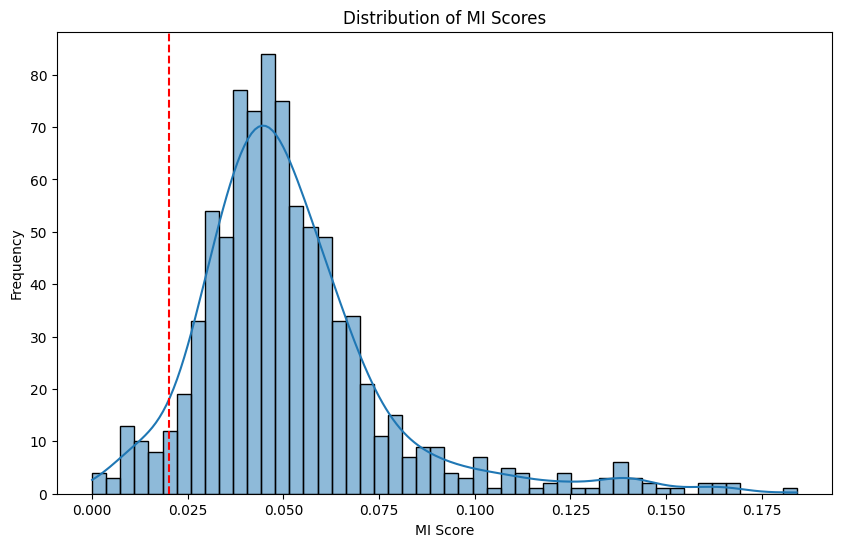

In [ ]:
def calculate_MI_scores(radiomics_df, class_col='diag'):
    """
    Calculates mutual information (MI) scores between each radiomics feature and the class label.

    Args:
        radiomics_df (pandas.DataFrame): DataFrame containing radiomics features and the class label.
        class_col (str): Name of the column within 'radiomics_df' containing the class label.

    Returns:
        pandas.DataFrame: DataFrame with feature names as the index and their corresponding MI scores
            in the 'MI_score' column.
    """
    feature_cols = radiomics_df.columns.difference(['filename', class_col])
    mi_scores = mutual_info_classif(radiomics_df[feature_cols], radiomics_df[class_col], discrete_features='auto')
    mi_scores = pd.DataFrame(mi_scores, index=feature_cols, columns=['MI_score'])
    return mi_scores

def select_features_mi_correlation(features_df, mi_df, target_col, corr_threshold=0.9, num_features=100, mi_threshold=10):
    """
    Selects features based on Mutual Information (MI), correlation filtering, and an MI threshold.

    Args:
        features_df: DataFrame containing the features and the target variable.
        mi_df: DataFrame containing the MI scores for each feature.
        target_col: Name of the column containing the target variable.
        corr_threshold: Threshold for determining high correlation.
        num_features: The desired number of features to select.
        mi_threshold: Threshold for percentile of MI score to remove features.

    Returns:
        List of selected feature names.
    """
    # Create a copy of features_df to not alter the original dataframe
    features_df_copy = features_df.copy()

    # Extract feature names, excluding the target column and filename column
    feature_cols = features_df_copy.columns.difference(['filename', target_col])

    # Sort MI scores in descending order
    mi_scores = mi_df.sort_values(by='MI_score', ascending=False)
    print(f"Original number of features: {len(mi_scores)}")

    assert len(mi_scores) == len(feature_cols), "Number of features and MI scores do not match."

    # Calculate mi_threshold_value by finding bottom 10 percentile
    mi_threshold_value = np.percentile(mi_scores['MI_score'], mi_threshold)
    print(f"MI threshold value corresponding to {mi_threshold}th percentile: {mi_threshold_value}")

    # Plot distribution of MI scores
    plt.figure(figsize=(10, 6))
    sns.histplot(mi_scores_all['MI_score'], bins=50, kde=True)
    plt.axvline(x=mi_threshold_value, color='r', linestyle='--', label=f'Bottom {mi_threshold}% Percentile: {mi_threshold_value:.2f}')
    plt.title('Distribution of MI Scores')
    plt.xlabel('MI Score')
    plt.ylabel('Frequency')

    # Filter features by the MI threshold
    mi_scores_filtered = mi_scores[mi_scores['MI_score'] > mi_threshold_value]
    print(f"Number of features after filtering by MI threshold: {len(mi_scores_filtered)}")

    # Update feature_cols to be the indexes from mi_scores_filtered
    feature_cols = mi_scores_filtered.index

    # If after MI thresholding there are fewer features than num_features, adjust num_features
    num_features = min(num_features, len(feature_cols))

    # Initialize selected features list
    selected_features = []

    # Calculate correlation matrix for the features
    correlation_matrix = features_df_copy[feature_cols].corr()

    # Feature selection process
    while len(selected_features) < num_features and not mi_scores_filtered.empty:
        # Get the feature with the highest MI score, append to selected features and drop from mi_scores_filtered
        current_feature = mi_scores_filtered.index[0]
        selected_features.append(current_feature)
        mi_scores_filtered = mi_scores_filtered.drop(current_feature)

        # Find features that are highly correlated with the current feature
        correlated_features = set(correlation_matrix[current_feature][correlation_matrix[current_feature] > corr_threshold].index)
        features_to_drop = set(correlated_features).intersection(mi_scores_filtered.index) | {current_feature}

        # Remove the selected feature and any highly correlated features from consideration
        mi_scores_filtered = mi_scores_filtered.drop(labels=features_to_drop, errors='ignore')
        mi_scores_filtered = mi_scores_filtered.sort_values(by='MI_score', ascending=False)

    print(f"Number of selected features: {len(selected_features)}")

    # Filter mi_scores to cases where index is in selected_features
    mi_scores_selected_features = mi_scores[mi_scores.index.isin(selected_features)]

    return selected_features, mi_scores_selected_features

# Add diagnostics column by concatenating df_train with df_radiomics_train on 'filename'
df_radiomics_train = pd.merge(df_radiomics_train, df_train[['filename', 'diag']], on='filename', how='left')

# Calculate MI scores for all features
# Try loading from pickle
if os.path.exists(f"{RADIOMICS_PATH_FULL}_mi_scores_all.pkl"):
    mi_scores_all = pd.read_pickle(f"{RADIOMICS_PATH_FULL}_mi_scores_all.pkl")
else:
    mi_scores_all = calculate_MI_scores(df_radiomics_train, class_col='diag')
    mi_scores_all.to_pickle(f"{RADIOMICS_PATH_FULL}_mi_scores_all.pkl")

selected_features, mi_scores_selected_features = select_features_mi_correlation(df_radiomics_train, mi_scores_all, 'diag',
                                                                                corr_threshold=0.95, num_features=1000,
                                                                                mi_threshold=5)

In [ ]:
df_radiomics_train.columns

Index(['filename', 'original_firstorder_10Percentile',
       'original_firstorder_90Percentile', 'original_firstorder_Energy',
       'original_firstorder_Entropy', 'original_firstorder_InterquartileRange',
       'original_firstorder_Kurtosis', 'original_firstorder_Maximum',
       'original_firstorder_MeanAbsoluteDeviation', 'original_firstorder_Mean',
       ...
       'gradient_gldm_GrayLevelVariance',
       'gradient_gldm_HighGrayLevelEmphasis',
       'gradient_gldm_LargeDependenceEmphasis',
       'gradient_gldm_LargeDependenceHighGrayLevelEmphasis',
       'gradient_gldm_LargeDependenceLowGrayLevelEmphasis',
       'gradient_gldm_LowGrayLevelEmphasis',
       'gradient_gldm_SmallDependenceEmphasis',
       'gradient_gldm_SmallDependenceHighGrayLevelEmphasis',
       'gradient_gldm_SmallDependenceLowGrayLevelEmphasis', 'diag'],
      dtype='object', length=866)

<Figure size 1200x1200 with 0 Axes>

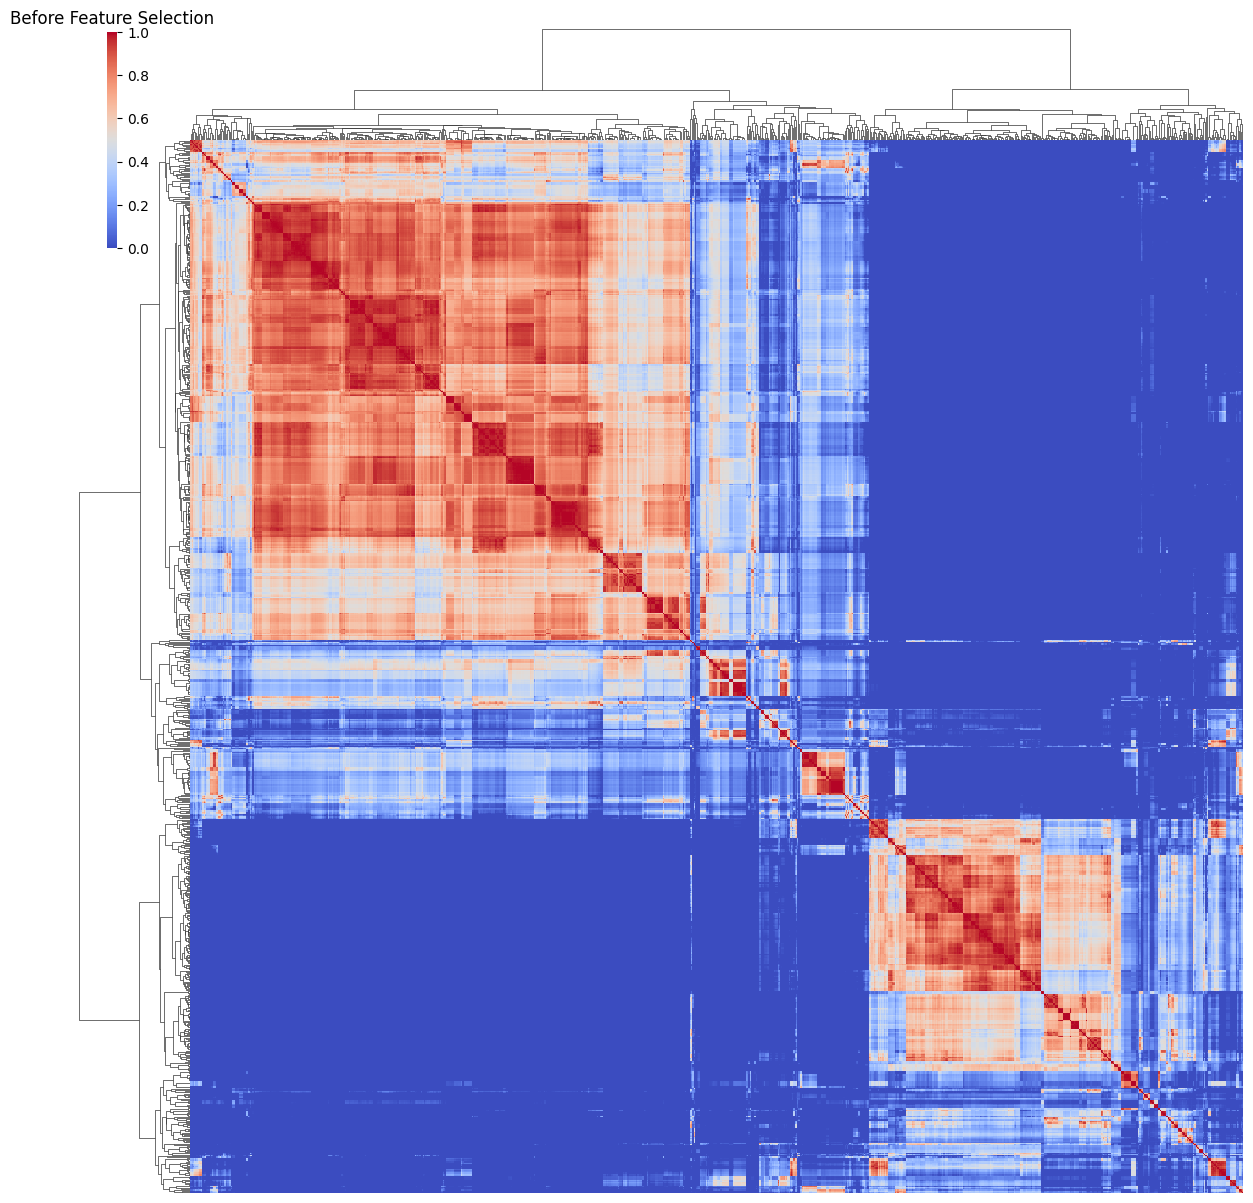

<Figure size 1200x1200 with 0 Axes>

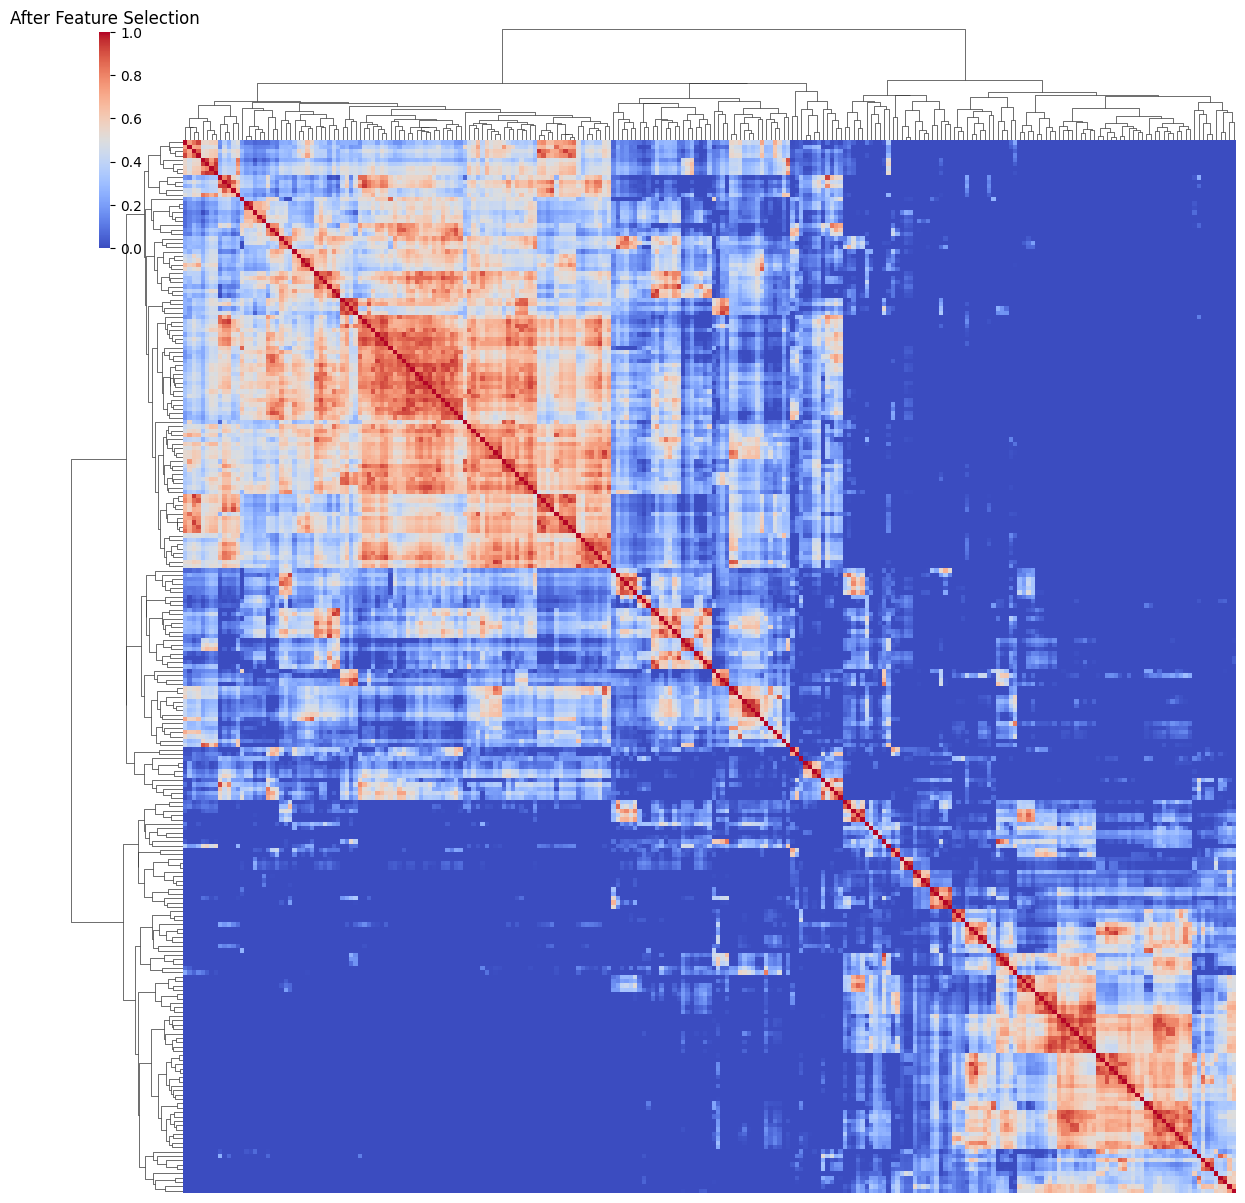

In [ ]:
# @title Vis: Correlations before and after feature selection
def plot_correlations_before_after_selection(df=df_radiomics_train, feature_cols=selected_features, figsize=(12, 12), dendrogram_ratio=0.1, export_path_1='reports/figures/radiomics_corr_before_selection.png', export_path_2='reports/figures/radiomics_corr_after_selection.png'):
    """
    Plots clustermaps of correlations before and after feature selection

    Args:
      df (pandas.DataFrame): DataFrame containing the features.
      feature_cols (list): List of selected features after feature selection.
      figsize (tuple): Figure size for the clustermaps.
      dendrogram_ratio (float): Ratio of the figure dedicated to the dendrogram.
      export_path_1 (str): Path to export the first clustermap.
      export_path_2 (str): Path to export the second clustermap.

    Returns:
      None
    """
    # Remove columns not used in correlation calculation
    df_before = df.copy().drop(columns=['filename', 'diag'])

    # Compute correlation matrices
    corr_before = df_before.corr()
    corr_after = df[feature_cols].corr()

    # Plot clustermap for correlation before feature selection
    plt.figure(figsize=figsize)
    g1 = sns.clustermap(corr_before, annot=False, cmap='coolwarm',
                        xticklabels=False, yticklabels=False, vmin=0, vmax=1,
                        figsize=figsize, dendrogram_ratio=dendrogram_ratio)
    g1.cax.set_aspect(20)
    plt.title('Before Feature Selection')
    plt.show()

    # Plot clustermap for correlation after feature selection
    plt.figure(figsize=figsize)
    g2 = sns.clustermap(corr_after, annot=False, cmap='coolwarm',
                        xticklabels=False, yticklabels=False, vmin=0, vmax=1,
                        figsize=figsize, dendrogram_ratio=dendrogram_ratio)
    g2.cax.set_aspect(20)
    plt.title('After Feature Selection')
    plt.show()

    # Save figures if paths are provided
    if export_path_1:
        g1.savefig(export_path_1)
    if export_path_1:
        g2.savefig(export_path_2)

def combine_images_side_by_side(image_path1, image_path2, output_path):
    """
    Combines two images side by side and saves the result.

    Args:
      image_path1 (str): Path to the first image file.
      image_path2 (str): Path to the second image file.
      output_path (str): Path where the combined image will be saved.

    Returns:
      None
    """
    # Open the images
    img1 = Image.open(image_path1)
    img2 = Image.open(image_path2)

    # Get maximum height of the two images
    max_height = max(img1.size[1], img2.size[1])

    # Create a new image with a width equal to the sum of both images' widths
    # and the height equal to the maximum of both images' heights
    total_width = img1.size[0] + img2.size[0]
    new_img = Image.new('RGB', (total_width, max_height))

    # Paste the images into the new image
    new_img.paste(img1, (0, 0))
    new_img.paste(img2, (img1.size[0], 0))

    # Save the new image
    new_img.save(output_path)

PATH_TO_CORR_BEFORE = 'reports/figures/radiomics_corr_before_selection.png'
PATH_TO_CORR_AFTER = 'reports/figures/radiomics_corr_after_selection.png'

plot_correlations_before_after_selection(export_path_1 = PATH_TO_CORR_BEFORE, export_path_2 = PATH_TO_CORR_AFTER)
combine_images_side_by_side(PATH_TO_CORR_BEFORE, PATH_TO_CORR_AFTER, 'reports/figures/radiomics_corr_before_after_selection.png')

In [ ]:
mi_scores_selected_features

MI_score
gradient_firstorder_InterquartileRange              0.184121
wavelet-HL_glcm_SumAverage                          0.166050
wavelet3-LL_firstorder_Skewness                     0.152836
wavelet2-LH_glcm_JointAverage                       0.144038
wavelet2-HL_glcm_Autocorrelation                    0.142321
...                                                      ...
wavelet-LH_gldm_SmallDependenceLowGrayLevelEmph...  0.022589
wavelet2-HH_firstorder_Mean                         0.022331
wavelet3-LH_gldm_DependenceVariance                 0.022290
original_glrlm_LongRunLowGrayLevelEmphasis          0.021389
wavelet3-HH_firstorder_Median                       0.021367

[241 rows x 1 columns]

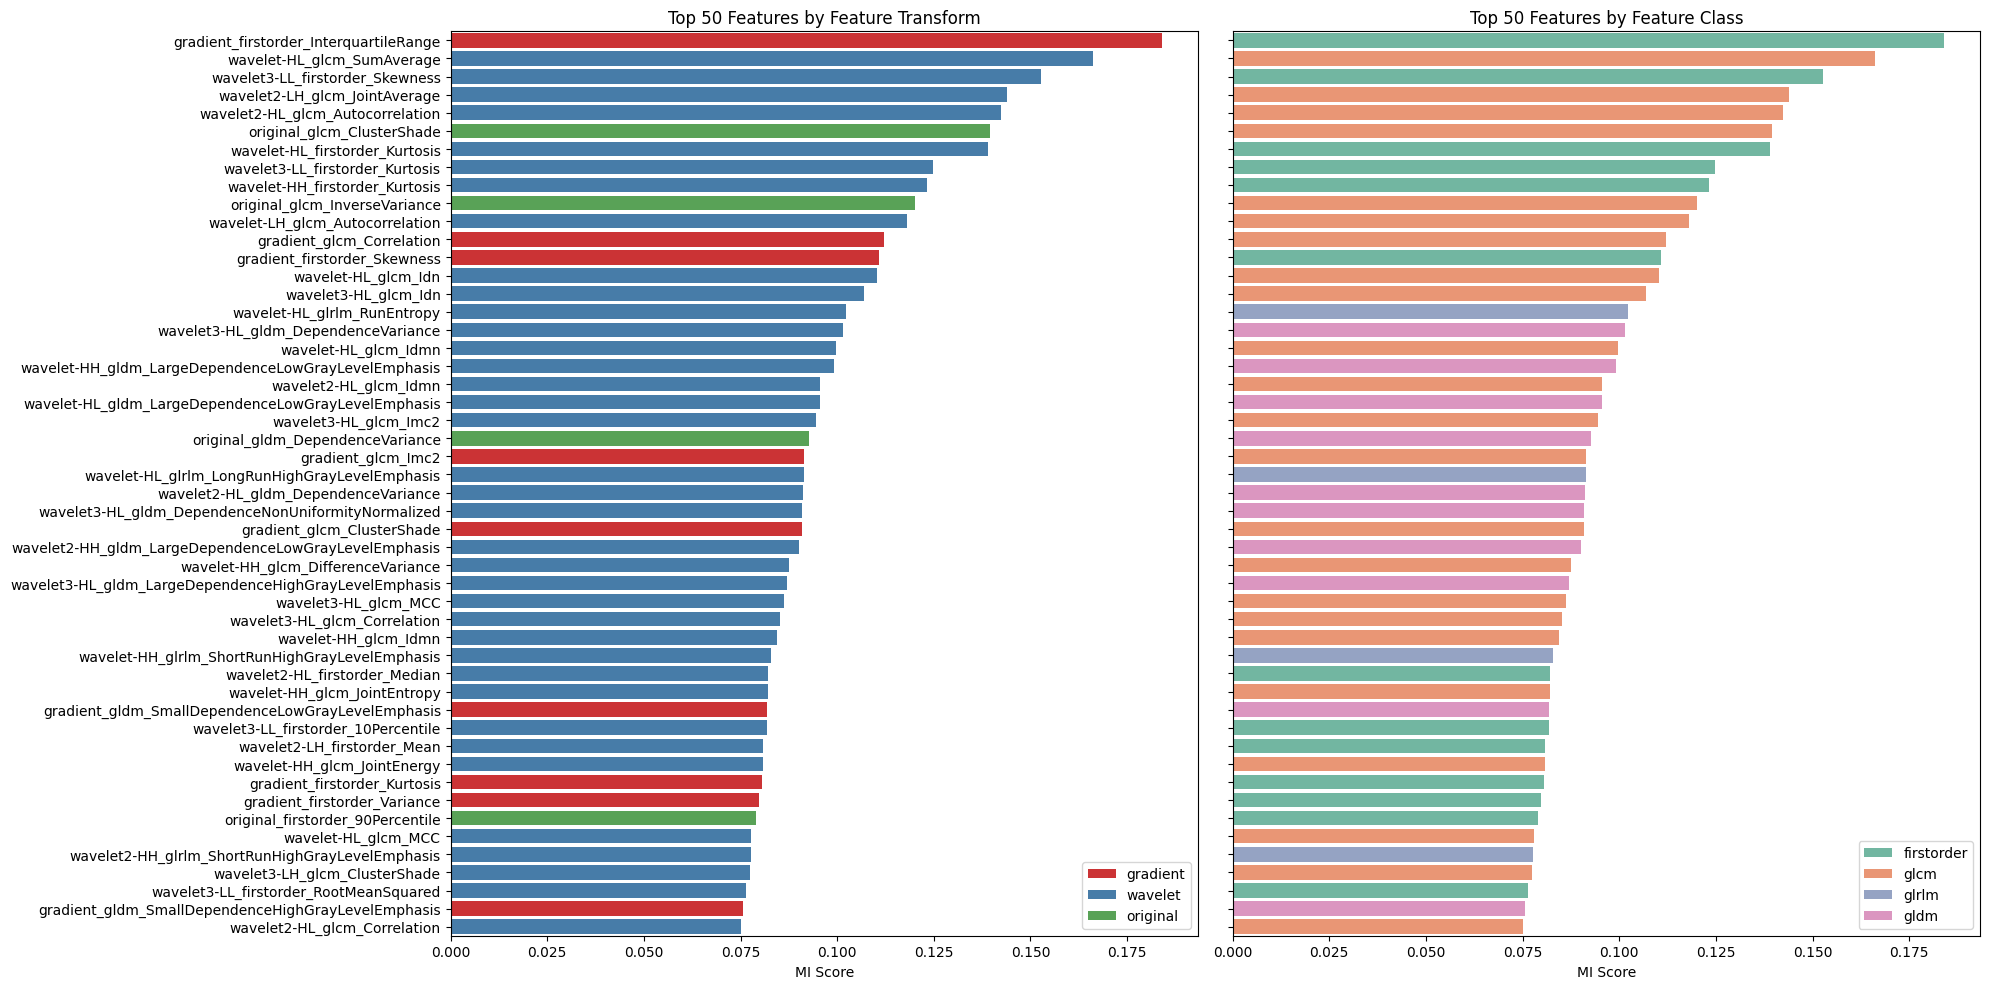

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [ ]:
# @title Vis: Bar chart of features with top MI scores
def plot_top_mi_scores(mi_scores, n=50, color_by_1='feature_transform', color_by_2='feature_class', figsize=(20,10), export_path='reports/figures/radiomics_top_50_features.png'):
    """
    Plots the top MI scores for the given DataFrame, with bars colored by a specified attribute.

    Args:
      mi_scores (pandas.DataFrame): DataFrame containing the MI scores.
      n (int): Number of top MI scores to plot.
      color_by (str): Attribute to color bars by. Must be one of: 'feature_transform', 'feature_class', 'feature_name'.
      export_path (str, optional): Path to export the plot image.

    Returns:
      None
    """
    top_mi_scores = mi_scores.sort_values(by='MI_score', ascending=False).head(n)

    splitted_index = top_mi_scores.index.str.split('_')
    top_mi_scores['feature_transform'] = splitted_index.str[0]
    top_mi_scores['feature_transform'] = top_mi_scores['feature_transform'].apply(lambda x: 'wavelet' if 'wavelet' in x else x)
    top_mi_scores['feature_transform'] = top_mi_scores['feature_transform'].where(~top_mi_scores['feature_transform'].str.contains('wavelet'), 'wavelet')
    top_mi_scores['feature_class'] = splitted_index.str[1]
    top_mi_scores['feature_name'] = splitted_index.str[2]

    if color_by_1 == 'feature_transform':
        color_by_1_name = 'Feature Transform'
    elif color_by_1 == 'feature_class':
        color_by_1_name = 'Feature Class'
    else:
        color_by_1_name = 'Feature Name'

    if color_by_2 == 'feature_transform':
        color_by_2_name = 'Feature Transform'
    elif color_by_2 == 'feature_class':
        color_by_2_name = 'Feature Class'
    else:
        color_by_2_name = 'Feature Name'

    # Create subplots with shared y-axis
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize, sharey=True)  # Enables shared y-axis

    # Plot for the first attribute
    g1 = sns.barplot(x='MI_score', y=top_mi_scores.index, hue=color_by_1, data=top_mi_scores, dodge=False, ax=ax1, palette='Set1')
    g1.legend()
    g1.set_xlabel('MI Score')
    g1.set_ylabel(None)
    ax1.set_title(f"Top {n} Features by {color_by_1_name}")

    # Plot for the second attribute
    g2 = sns.barplot(x='MI_score', y=top_mi_scores.index, hue=color_by_2, data=top_mi_scores, dodge=False, ax=ax2, palette='Set2')
    g2.legend()
    g2.set_xlabel('MI Score')
    g2.set_ylabel(None)
    ax2.set_title(f"Top {n} Features by {color_by_2_name}")

    plt.tight_layout()
    plt.show()

    ax1.set_title(f"Top {n} features by {color_by_1_name}")
    ax2.set_title(f"Top {n} features by {color_by_2_name}")

    plt.tight_layout()
    plt.show()

    if export_path:
        plt.savefig(export_path)

plot_top_mi_scores(mi_scores_selected_features, n=30, export_path='reports/figures/radiomics_mi_top_features.png')

### Extract radiomics features for all dataframes

In [ ]:
# @title Filter train to selected features
if not os.path.exists(f"{RADIOMICS_PATH_FULL}_filtered_train.pkl"):
    df_radiomics_train = df_radiomics_train[['filename', 'diag'] + selected_features]
    assert df_radiomics_train.shape[0] == df_train.shape[0], f"Number of rows in df_radiomics_train {df_radiomics_train.shape[0]} does not match number of rows in df_train {df_train.shape[0]}"
    df_radiomics_train.to_pickle(f"{RADIOMICS_PATH_FULL}_filtered_train.pkl")
else:
    df_radiomics_train = pd.read_pickle(f"{RADIOMICS_PATH_FULL}_filtered_train.pkl")

In [ ]:
# @title Compile settings file to only extract relevant features
def update_radiomics_settings_featurelist(settings, selected_features):
    """
    Updates a radiomics settings dictionary with the selected features.

    Parameters:
    - settings: The radiomics settings dictionary.
    - selected_features: The list of selected features.

    Returns:
    - The updated radiomics settings dictionary.
    """
    # Organize features by their class
    feature_classes = {class_name: [] for class_name in ['firstorder', 'shape', 'glcm', 'glrlm', 'gldm', 'ngtdm', 'glszm']}

    for feature in selected_features:
        split_name = feature.split('_')
        if len(split_name) > 2:
            # Assuming feature naming convention as: type_class_featureName
            feature_class = split_name[1].lower()
            if feature_class in feature_classes:
                feature_classes[feature_class].append('_'.join(split_name[2:]))

    # Augment settings for each feature class
    for feature_class, features in feature_classes.items():
        if features:
            if feature_class in settings:
                # Use set to remove duplicates before extending
                current_features = set(settings[feature_class].get('features', []))
                settings[feature_class]['features'] = list(current_features | set(features))
            else:
                settings[feature_class] = {'enabled': True, 'features': list(set(features))}  # Use set here too

    return settings

# Update radiomics_settings with selected features
radiomics_settings = load_radiomics_settings(RADIOMICS_SETTINGS_PATH)
radiomics_settings_featurelist = update_radiomics_settings_featurelist(radiomics_settings, selected_features)

Radiomics settings loaded successfully.


In [ ]:
# @title Extract, postprocess and filter irrelevant features for val and train
def extract_postprocess_filter_radiomics_features(df, data_type, selected_features=selected_features, settings=radiomics_settings_featurelist, batch_size=300, force_run=False):
    """
    Extract radiomics features from the input images using the PyRadiomics library, applies post-processing and filtering to selected features and exports to pickle file.

    Parameters:
    - df: DataFrame containing the images and masks. It must contain the columns 'filename', 'diag', 'split', 'image_normalized', 'mask_original'.
    - data_type: Type of data (e.g., 'train', 'val', 'test').
    - selected_features: List of selected features.
    - settings: Settings for pyradiomics
    - batch_size: Number of samples to process per batch of processing pyradiomics
    - force_run: Flag to force re-running pyradiomics if the feature extraction has already been run

    Returns:
    - df_radiomics: DataFrame containing the radiomics features.
    """
    assert data_type in ['train', 'val', 'test'], f"Invalid data_type: {data_type}"

    if os.path.exists(f"{RADIOMICS_PATH_FULL}_filtered_{data_type}.pkl") and not force_run:
        print(f"Loading radiomics features from {RADIOMICS_PATH_FULL}_filtered_{data_type}.pkl")
        df_radiomics = pd.read_pickle(f"{RADIOMICS_PATH_FULL}_filtered_{data_type}.pkl")
        return df_radiomics

    # Extract in batches
    df_radiomics = process_radiomics_in_batches(
        df=df[['filename', 'diag', 'split', 'image_normalized', 'mask_original']],
        data_type=data_type,
        settings=radiomics_settings,
        image_types=['Original', 'Wavelet', 'Gradient'],
        feature_names=['firstorder', 'glcm', 'glrlm', 'gldm'],
        img_col='image_normalized',
        mask_col='mask_original',
        force_run=force_run,
        batch_size=batch_size,
        base_outfile_path=RADIOMICS_PATH
    )

    # Post-process
    df_radiomics = postprocess_radiomics_df(df_radiomics, data_type=data_type)

    # Filter
    df_radiomics = df_radiomics[['filename'] + selected_features]
    print(f"Shape after selecting only relevant columns: {df_radiomics.shape}")

    # Merge 'diag' into df_radiomics
    df_radiomics = df_radiomics.merge(df[['filename', 'diag']], on='filename', how='left')
    print(f"Shape after merging 'diag' into df_radiomics: {df_radiomics.shape}")

    # Save as pickle file
    df_radiomics.to_pickle(f"{RADIOMICS_PATH_FULL}_filtered_{data_type}.pkl")
    return df_radiomics

df_radiomics_val = extract_postprocess_filter_radiomics_features(df_val, data_type='val', selected_features=selected_features, settings=radiomics_settings_featurelist, batch_size=300, force_run=False)
assert df_radiomics_val.shape[0] == df_val.shape[0], "Number of rows in df_radiomics_val does not match number of rows in df_val"

df_radiomics_test = extract_postprocess_filter_radiomics_features(df_test, data_type='test', selected_features=selected_features, settings=radiomics_settings_featurelist, batch_size=300, force_run=False)
assert df_radiomics_test.shape[0] == df_test.shape[0], "Number of rows in df_radiomics_test does not match number of rows in df_test"

assert len(df_radiomics_train.columns) == len(df_radiomics_val.columns) == len(df_radiomics_test.columns), "Number of columns in all dataframes is not the same"
assert set(df_radiomics_train.columns.tolist()) == set(df_radiomics_val.columns.tolist()) == set(df_radiomics_test.columns.tolist()), "Column names are not the same"

Loading radiomics features from data/interim/RADIOMICS/RADIOMICS_features_full_filtered_val.pkl
Loading radiomics features from data/interim/RADIOMICS/RADIOMICS_features_full_filtered_test.pkl


### Visualizations

In [ ]:
def tsne_radiomics_visualization(df, n_components=3, random_seed=RANDOM_STATE, export_path=None):
    """
    Performs t-SNE on the radiomics features and visualizes the result, coloring by 'diag'.
    Supports both 2D and 3D visualizations.

    Parameters:
    - df (pd.DataFrame): DataFrame containing the radiomics features and the diagnosis codes.
    - n_components (int, optional): Number of dimensions for t-SNE. Default is 3.
    - random_seed (int, optional): Random seed for reproducibility. Default is 42.
    - export_path (str, optional): Path to save the visualization. Default is None.
    """
    # Define feature_cols
    feature_cols = df.columns.difference(['filename', 'diag'])

    # Convert to format suitable for numpy
    radiomics_features = np.array(df[feature_cols])

    # Transpose the array to work with rows instead of columns
    radiomics_features_T = radiomics_features.T

    # Identify rows (originally columns) that don't contain any infinity values
    valid_rows = ~np.isinf(radiomics_features_T).any(axis=1)

    # Filter out rows with infinity, then transpose back
    cleaned_radiomics_features = radiomics_features_T[valid_rows].T

    print(f"Original shape: {radiomics_features.shape}, Cleaned shape: {cleaned_radiomics_features.shape}")

    # Perform t-SNE
    tsne = TSNE(n_components=n_components, random_state=random_seed)
    tsne_results = tsne.fit_transform(cleaned_radiomics_features)

    # Prepare for visualization
    tsne_col_names = [f'TSNE{i+1}' for i in range(n_components)]
    df_tsne = pd.DataFrame(tsne_results, columns=tsne_col_names)
    df_tsne['diag'] = df['diag'].values

    # Visualization
    if n_components == 3:
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')
        ax.set_xlabel('TSNE1')
        ax.set_ylabel('TSNE2')
        ax.set_zlabel('TSNE3')
    else:  # Default to 2D if not 3D
        fig, ax = plt.subplots(figsize=(10, 8))
        ax.set_xlabel('TSNE1')
        ax.set_ylabel('TSNE2')

    # Get unique labels for coloring
    labels = df['diag'].unique()

    # Plot each group
    for label in labels:
        indices = df_tsne['diag'] == label
        if n_components == 3:
            ax.scatter(df_tsne.loc[indices, 'TSNE1'], df_tsne.loc[indices, 'TSNE2'], df_tsne.loc[indices, 'TSNE3'], label=label)
        else:
            ax.scatter(df_tsne.loc[indices, 'TSNE1'], df_tsne.loc[indices, 'TSNE2'], label=label)

    ax.legend()
    plt.title(f't-SNE visualization of Radiomics Features')
    plt.show()

    if export_path is not None:
        plt.savefig(export_path)
        print(f"Saved visualization to {export_path}")

# tsne_radiomics_visualization(df_radiomics_train, n_components=2, export_path='reports/figures/tsne_radiomics_train.png')

## ResNet

In [ ]:
def create_resnet_df(df, img_col, data_type, batch_size=32,
                     base_outfile_path=RESNET_PATH, force_run=False, pooling=None):
    """
    Extracts ResNet embeddings and, optionally, applies global average and max pooling to these embeddings. The
    resulting embeddings are saved to a DataFrame, which includes separate columns for the original embeddings,
    global average pooled embeddings, and global max pooled embeddings, based on the specified pooling option.

    Parameters:
    - df (pd.DataFrame): Dataframe containing the images and metadata.
    - img_col (str): Column name in `df` containing the images.
    - data_type (str): Specifies the dataset type ('train', 'val', or 'test') for dynamic outfile path generation.
    - batch_size (int, optional): Number of images to process in each batch.
    - base_outfile_path (str, optional): File path to export to.
    - force_run (bool, optional): If True, embeddings will be recomputed even if outfile_path exists.
    - pooling (str, optional): Specifies whether to apply 'average', 'max', or both pooling operations.
      Use None for no additional pooling.

    Returns:
    - pd.DataFrame: A dataframe containing the embeddings and the original metadata from `df`.
    """
    assert pooling in [None, 'average', 'max', 'both'], "Invalid pooling option. Use None, 'average', 'max', or 'both'."

    outfile_path = f"{base_outfile_path}_{data_type}.pkl"
    if not force_run and os.path.exists(outfile_path):
        print(f"Loading embeddings from {outfile_path}")
        embeddings_df = pd.read_pickle(outfile_path)
        return embeddings_df

    print(f"{outfile_path} does not exist. Extracting RESNET embeddings")

    embeddings_df = pd.DataFrame()
    embeddings_df['filename'] = df['filename']
    embeddings_df['diag'] = df['diag']

    preprocess = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    model = models.resnet50(pretrained=True)
    model = torch.nn.Sequential(*list(model.children())[:-1])
    model.eval()
    model.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

    original_embeddings = []
    avg_pool_embeddings = []
    max_pool_embeddings = []

    for i in tqdm(range(0, len(df), batch_size), desc="Extracting embeddings"):
        batch = [preprocess(img).unsqueeze(0) for img in df[img_col][i:i+batch_size]]
        batch_tensors = torch.cat(batch).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

        with torch.no_grad():
            batch_embeddings = model(batch_tensors)
            batch_embeddings = torch.flatten(batch_embeddings, 1)
            original_embeddings.append(batch_embeddings.cpu().numpy())

            if pooling == 'average' or pooling == 'both':
                avg_pooled = torch.nn.functional.adaptive_avg_pool2d(batch_embeddings.unsqueeze(-1).unsqueeze(-1), (1, 1))
                avg_pool_embeddings.append(torch.flatten(avg_pooled, 1).cpu().numpy())

            if pooling == 'max' or pooling == 'both':
                max_pooled = torch.nn.functional.adaptive_max_pool2d(batch_embeddings.unsqueeze(-1).unsqueeze(-1), (1, 1))
                max_pool_embeddings.append(torch.flatten(max_pooled, 1).cpu().numpy())

    embeddings_df['resnet_embeddings'] = list(np.concatenate(original_embeddings, axis=0))

    if pooling == 'average' or pooling == 'both':
        embeddings_df['resnet_embeddings_avg'] = list(np.concatenate(avg_pool_embeddings, axis=0))

    if pooling == 'max' or pooling == 'both':
        embeddings_df['resnet_embeddings_max'] = list(np.concatenate(max_pool_embeddings, axis=0))

    embeddings_df.to_pickle(outfile_path, compression='infer')
    print(f"Saved embeddings to {outfile_path}")
    return embeddings_df

df_resnet_train = create_resnet_df(df_train, 'image_normalized', 'train', force_run=False)
df_resnet_val = create_resnet_df(df_val, 'image_normalized', 'val', force_run=False)
df_resnet_test = create_resnet_df(df_test, 'image_normalized', 'test', force_run=False)

assert df_resnet_train.shape[0] == df_train.shape[0], "Number of rows in df_train and df_resnet_train do not match."
assert df_resnet_val.shape[0] == df_val.shape[0], "Number of rows in df_val and df_resnet_val do not match."
assert df_resnet_test.shape[0] == df_test.shape[0], "Number of rows in df_test and df_resnet_test do not match."
assert df_resnet_train.shape[1] == df_resnet_val.shape[1] == df_resnet_test.shape[1], "Number of columns in df_resnet_train, df_resnet_val, and df_resnet_test do not match."

Loading embeddings from data/interim/RESNET/RESNET_features_full_train.pkl
Loading embeddings from data/interim/RESNET/RESNET_features_full_val.pkl
Loading embeddings from data/interim/RESNET/RESNET_features_full_test.pkl


## Merge dataframes and export as pickle files

In [ ]:
def merge_dataframes(df_original, df_hog, df_radiomics, df_resnet, cols_to_keep):
    """
    Merges the given dataframes into a single dataframe based on 'filename' column, keeping specific columns
    from the original dataframe and ensuring the number of rows remains consistent after each merge.
    Specifically ensures that 'diag' column from df_hog, df_radiomics, and df_resnet are not included in the final merged dataframe.

    Parameters:
    - df_original: The original dataframe.
    - df_hog: The dataframe containing the HOG features.
    - df_radiomics: The dataframe containing the Radiomics features.
    - df_resnet: The dataframe containing the ResNet features.
    - cols_to_keep: A list of column names to keep from the original dataframe.

    Returns:
    - merged_df: The merged dataframe.
    """
    # Make a copy of the original dataframe with only the columns to keep
    merged_df = df_original[cols_to_keep].copy()
    print(f"Original shape: {merged_df.shape}")

    # Initial row count for assertions
    initial_row_count = merged_df.shape[0]

    # Function for merging dataframes while excluding 'diag' column from the others
    def _merge_and_assert(df_to_merge, merged_df):
        # Filter out 'diag' column if present, besides other overlapping columns except 'filename'
        columns_to_exclude = ['diag']
        df_to_merge_filtered = df_to_merge.drop(columns=columns_to_exclude, errors='ignore')
        merged = pd.merge(merged_df, df_to_merge_filtered, on='filename', how='left')
        # Assert to ensure the row count remains unchanged
        assert merged.shape[0] == initial_row_count, "Row count changed after merge."
        return merged

    # Sequentially merge each dataframe, excluding 'diag' column from them
    merged_df = _merge_and_assert(df_hog, merged_df)
    merged_df = _merge_and_assert(df_radiomics, merged_df)
    merged_df = _merge_and_assert(df_resnet, merged_df)

    print(f"Merged shape: {merged_df.shape}")

    # Assert to ensure the row count remains unchanged
    assert merged_df.shape[0] == initial_row_count, "Row count changed after merge."

    return merged_df

def export_dataframe(df, data_type, base_export_path=FINAL_FEATURES_PATH):
    """
    Export the dataframe as a pickle file with a timestamp.

    Parameters:
    - df: The dataframe to export.
    - data_type: The type of data (train, val, or test).
    - base_export_path: The base path for the output files.
    """
    # Get the current timestamp
    current_timestamp = datetime.now().strftime('%y%m%d')

    # Export the dataframe as a pickle file
    outfile_path = f"{base_export_path}_{data_type}_{current_timestamp}.pkl.gz"
    print(f"Exporting dataframe to {outfile_path}...")

    df.to_pickle(outfile_path, compression='gzip')
    print(f"Dataframe exported as {outfile_path}")

LATEST_TIMESTAMP='240331'
if os.path.exists(f"{FINAL_FEATURES_PATH}_train_{LATEST_TIMESTAMP}.pkl.gz"):
    print(f"Loading dataframe from {FINAL_FEATURES_PATH}_train_{LATEST_TIMESTAMP}.pkl.gz")
    df_features_train = pd.read_pickle(f"{FINAL_FEATURES_PATH}_train_{LATEST_TIMESTAMP}.pkl.gz")
else:
    print(f"No dataframe found at {FINAL_FEATURES_PATH}_train_{LATEST_TIMESTAMP}.pkl.gz")
    df_features_train = merge_dataframes(df_train, df_hog_train, df_radiomics_train, df_resnet_train, cols_to_keep=['filename', 'diag', 'split', 'image_normalized', 'image_processed'])
    export_dataframe(df_features_train, 'train')

if os.path.exists(f"{FINAL_FEATURES_PATH}_val_{LATEST_TIMESTAMP}.pkl.gz"):
    print(f"Loading dataframe from {FINAL_FEATURES_PATH}_val_{LATEST_TIMESTAMP}.pkl.gz")
    df_features_val = pd.read_pickle(f"{FINAL_FEATURES_PATH}_val_{LATEST_TIMESTAMP}.pkl.gz")
else:
    print(f"No dataframe found at {FINAL_FEATURES_PATH}_val_{LATEST_TIMESTAMP}.pkl.gz")
    df_features_val = merge_dataframes(df_val, df_hog_val, df_radiomics_val, df_resnet_val, cols_to_keep=['filename', 'diag', 'split', 'image_normalized', 'image_processed'])
    export_dataframe(df_features_val, 'val')

if os.path.exists(f"{FINAL_FEATURES_PATH}_test_{LATEST_TIMESTAMP}.pkl.gz"):
    print(f"Loading dataframe from {FINAL_FEATURES_PATH}_test_{LATEST_TIMESTAMP}.pkl.gz")
    df_features_test = pd.read_pickle(f"{FINAL_FEATURES_PATH}_test_{LATEST_TIMESTAMP}.pkl.gz")
else:
    print(f"No dataframe found at {FINAL_FEATURES_PATH}_test_{LATEST_TIMESTAMP}.pkl.gz")
    df_features_test = merge_dataframes(df_test, df_hog_test, df_radiomics_test, df_resnet_test, cols_to_keep=['filename', 'diag', 'split', 'image_normalized', 'image_processed'])
    export_dataframe(df_features_test, 'test')

Loading dataframe from data/interim/ALL_FEATURES/ALL_features_full_train_240331.pkl.gz


In [ ]:
if os.path.exists(f"{FINAL_FEATURES_PATH}_val_{LATEST_TIMESTAMP}.pkl.gz"):
    print(f"Loading dataframe from {FINAL_FEATURES_PATH}_val_{LATEST_TIMESTAMP}.pkl.gz")
    df_features_val = pd.read_pickle(f"{FINAL_FEATURES_PATH}_val_{LATEST_TIMESTAMP}.pkl.gz")
else:
    print(f"No dataframe found at {FINAL_FEATURES_PATH}_val_{LATEST_TIMESTAMP}.pkl.gz")
    df_features_val = merge_dataframes(df_val, df_hog_val, df_radiomics_val, df_resnet_val, cols_to_keep=['filename', 'diag', 'split', 'image_normalized', 'image_processed'])
    export_dataframe(df_features_val, 'val')

if os.path.exists(f"{FINAL_FEATURES_PATH}_test_{LATEST_TIMESTAMP}.pkl.gz"):
    print(f"Loading dataframe from {FINAL_FEATURES_PATH}_test_{LATEST_TIMESTAMP}.pkl.gz")
    df_features_test = pd.read_pickle(f"{FINAL_FEATURES_PATH}_test_{LATEST_TIMESTAMP}.pkl.gz")
else:
    print(f"No dataframe found at {FINAL_FEATURES_PATH}_test_{LATEST_TIMESTAMP}.pkl.gz")
    df_features_test = merge_dataframes(df_test, df_hog_test, df_radiomics_test, df_resnet_test, cols_to_keep=['filename', 'diag', 'split', 'image_normalized', 'image_processed'])
    export_dataframe(df_features_test, 'test')

Loading dataframe from data/interim/ALL_FEATURES/ALL_features_full_val_240331.pkl.gz
Loading dataframe from data/interim/ALL_FEATURES/ALL_features_full_test_240331.pkl.gz


In [ ]:
# @title Temporary fix to alter dataframes and re-export
# Note: This fixes an issue with HOG columns being removed in a previous version
# # Check if 'df_features_train' is not in globals, then load
# if 'df_features_train' not in globals():
#     with gzip.open('data/interim/ALL_FEATURES/ALL_features_train_240330.pkl', 'rb') as f:
#         df_features_train = pickle.load(f)

# # Check if 'df_features_val' is not in globals, then load
# if 'df_features_val' not in globals():
#     with gzip.open('data/interim/ALL_FEATURES/ALL_features_val_240330.pkl', 'rb') as f:
#         df_features_val = pickle.load(f)

# # Check if 'df_features_test' is not in globals, then load
# if 'df_features_test' not in globals():
#     with gzip.open('data/interim/ALL_FEATURES/ALL_features_test_240330.pkl', 'rb') as f:
#         df_features_test = pickle.load(f)

# print(f"Shape of df_features_train: {df_features_train.shape}")
# print(f"Shape of df_features_val: {df_features_val.shape}")
# print(f"Shape of df_features_test: {df_features_test.shape}")

# def alter_dataframe(df_features, df_features_single, cols_to_alter):
#   """
#   Alters the dataframe by replacing the values in the specified columns with those in the df_features dataframe.
#   The altered dataframe is returned.

#   Parameters:
#   - df_features (pd.DataFrame): The original dataframe with HOG, Radiomics, and ResNet features.
#   - df_features_single (pd.DataFrame): The dataframe containing the values to be altered.
#   - cols_to_alter (list): A list of column names to be altered.

#   Returns:
#   - df (pd.DataFrame): Altered dataframe.
#   """
#   original_shape = df_features.shape

#   print(f"\nAltering {cols_to_alter}...")

#   # Initial checks
#   assert all(col in df_features.columns for col in cols_to_alter), "Columns to alter not found in df_features."
#   assert all(col in df_features_single.columns for col in cols_to_alter), "Columns to alter not found in df_features_single."
#   assert df_features.shape[0] == df_features_single.shape[0], "Number of rows in df_features and df_features_single do not match."
#   assert 'filename' in df_features.columns and 'filename' in df_features_single.columns, "Columns 'filename' not found in df_features or df_features_single."

#   # Check that the shapes of the columns to alter are the same
#   print(f"Shape of df_features prior to altering: {df_features.shape}")
#   for col in cols_to_alter:
#     print(f"Shape of {col} prior to altering: {df_features[col].iloc[0].shape}")

#   # Drop cols_to_alter from df_features
#   df_features = df_features.drop(columns=cols_to_alter)
#   print(f"Shape of df_features after dropping columns to alter: {df_features.shape}")

#   # Left join df_features into df_features
#   df_features = pd.merge(df_features, df_features_single[['filename'] + cols_to_alter], on='filename', how='left')
#   print(f"\nShape of df_features after readding columns to alter: {df_features.shape}")
#   for col in cols_to_alter:
#     print(f"Shape of {col} after altering: {df_features[col].iloc[0].shape}")

#   # Ensure row counts remain unchanged
#   assert df_features.shape == original_shape, "Shape of df_features has changed after altering."

#   return df_features

# def export_dataframe(df, data_type, base_export_path=FINAL_FEATURES_PATH):
#     """
#     Export the dataframe as a pickle file with a timestamp.

#     Parameters:
#     - df: The dataframe to export.
#     - data_type: The type of data (train, val, or test).
#     - base_export_path: The base path for the output files.
#     """
#     # Get the current timestamp
#     current_timestamp = datetime.now().strftime('%y%m%d')

#     # Export the dataframe as a pickle file
#     outfile_path = f"{base_export_path}_{data_type}_{current_timestamp}.pkl"
#     print(f"Exporting dataframe to {outfile_path}...")

#     df.to_pickle(outfile_path, compression='gzip')
#     print(f"Dataframe exported as {outfile_path}")

# df_features_train_2 = alter_dataframe(df_features_train, df_hog_train, ['hog_features', 'hog_image'])
# df_features_val_2 = alter_dataframe(df_features_val, df_hog_val, ['hog_features', 'hog_image'])
# df_features_test_2 = alter_dataframe(df_features_test, df_hog_test, ['hog_features', 'hog_image'])

# export_dataframe(df_features_train_2, 'train')
# export_dataframe(df_features_val_2, 'val')
# export_dataframe(df_features_test_2, 'test')

## tSNE

In [ ]:
def preprocess_tsne_pca(df):
  """
  Preprocess the dataframe for t-SNE visualization or pca.

  Parameters:
  - df: The dataframe to preprocess.

  Returns:
  - df: The preprocessed dataframe.
  """
  # Make a copy
  df = df.copy()

  # Convert all radiomics columns into a single column
  radiomics_columns = df.columns.difference(['filename', 'diag', 'split', 'hog_features', 'hog_image', 'resnet_embeddings', 'image_normalized', 'image_processed', 'all_features', 'radiomics_features'])
  radiomics_columns_len = len(radiomics_columns.tolist())
  df['radiomics_features'] = df[radiomics_columns].apply(lambda row: np.array(row), axis=1)
  assert df['radiomics_features'].iloc[0].shape == (radiomics_columns_len,)

  # Concatenate hog, radiomics and resnet
  df['all_features'] = df[['hog_features', 'radiomics_features', 'resnet_embeddings']].apply(lambda row: np.concatenate(row), axis=1)
  assert df['all_features'].iloc[0].shape == (df['hog_features'].iloc[0].shape[0] + df['radiomics_features'].iloc[0].shape[0] + df['resnet_embeddings'].iloc[0].shape[0],)

  print(f"Shape of HOG_features: {df['hog_features'].iloc[0].shape}")
  print(f"Shape of Radiomics_features: {df['radiomics_features'].iloc[0].shape}")
  print(f"Shape of Resnet_embeddings: {df['resnet_embeddings'].iloc[0].shape}")
  print(f"Shape of all_features: {df['all_features'].iloc[0].shape}")

  # Only keep relevant columns
  df = df[['diag', 'hog_features', 'radiomics_features', 'resnet_embeddings', 'all_features']]

  return df

df_tsne = preprocess_tsne_pca(df_features_train)

Shape of HOG_features: (13689,)
Shape of Radiomics_features: (241,)
Shape of Resnet_embeddings: (2048,)
Shape of all_features: (15978,)


In [ ]:
def compute_tsne_features(df, feature_cols=['hog_features', 'radiomics_features', 'resnet_embeddings'], n_components=2, perplexity=50, random_seed=RANDOM_STATE, export_path='data/interim/tsne_train_df.pkl'):
    """
    Computes t-SNE for specified features and adds the results as new columns in the DataFrame.

    Parameters:
    - df: DataFrame containing features.
    - feature_cols: List of column names containing the features to compute t-SNE for.
    - n_components: Number of dimensions for t-SNE (2 or 3).
    - random_seed: Seed for random state in t-SNE.

    Returns:
    - DataFrame with new t-SNE columns added.
    """
    if os.path.exists(export_path):
        df = pd.read_pickle(export_path)
        return df

    tsne_results = {}
    for feature_col in tqdm(feature_cols):
        features = np.array(df[feature_col].tolist()).astype(np.float32)
        tsne = TSNE(n_components=n_components, perplexity=perplexity, random_state=random_seed)
        tsne_result = tsne.fit_transform(features)
        tsne_results[feature_col] = tsne_result

    for feature_col, result in tsne_results.items():
        for i in range(n_components):
            df[f'{feature_col}_TSNE{i+1}'] = result[:, i]

    df.to_pickle(export_path)

    return df

df_tsne = compute_tsne_features(df_tsne)



  0%|          | 0/3 [00:00<?, ?it/s]

 33%|███▎      | 1/3 [03:46<07:32, 226.28s/it]

 67%|██████▋   | 2/3 [05:36<02:38, 158.17s/it]

Processing t-SNE:   0%|          | 0/3 [26:33<?, ?run/s]


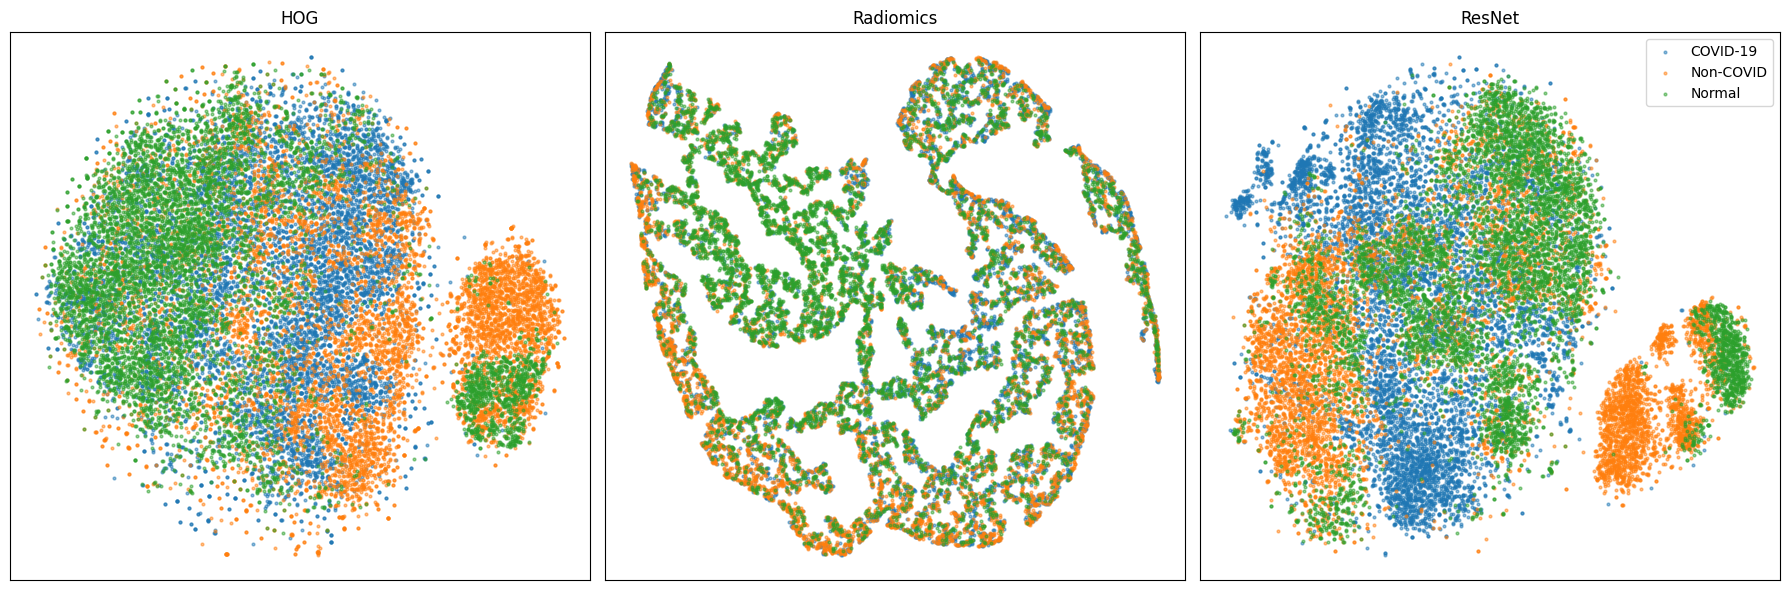

In [ ]:
def plot_tsne(df, feature_cols=['hog_features', 'radiomics_features', 'resnet_embeddings'], diag_col='diag', n_components=2, s=5, export_path='reports/figures/tsne_combined_2D.png'):
    """
    Plots t-SNE results stored in a DataFrame.

    Parameters:
    - df: DataFrame containing t-SNE results and diagnostic labels.
    - feature_cols: List of base names for columns containing t-SNE results.
    - diag_col: Column name for diagnostic labels.
    - n_components: Number of dimensions of t-SNE (2 or 3).
    - export_path: Path to save the visualization. If None, no export is performed.
    """
    fig = plt.figure(figsize=(6 * len(feature_cols), 6))
    axes = [fig.add_subplot(1, len(feature_cols), i + 1, projection='3d' if n_components == 3 else None) for i in range(len(feature_cols))]

    feature_mapping = {
        'hog_features': 'HOG',
        'radiomics_features': 'Radiomics',
        'resnet_embeddings': 'ResNet'
    }

    for ax, feature_col in zip(axes, feature_cols):
        tsne_col_names = [f'{feature_col}_TSNE{i+1}' for i in range(n_components)]
        labels = df[diag_col].unique()
        for label in labels:
            indices = df[diag_col] == label
            if n_components == 3:
                ax.scatter(df.loc[indices, tsne_col_names[0]], df.loc[indices, tsne_col_names[1]], df.loc[indices, tsne_col_names[2]], label=label, alpha=0.5, s=s)
            else:
                ax.scatter(df.loc[indices, tsne_col_names[0]], df.loc[indices, tsne_col_names[1]], label=label, alpha=0.5, s=s)

            ax.set_title(f'{feature_mapping[feature_col]}')
            ax.tick_params(axis='both', which='both', size=0, labelbottom=False, labelleft=False)
            if n_components == 3:
                ax.tick_params(labelbottom=False, labelleft=False, labelright=False)

        if ax == axes[-1]:
            ax.legend(loc='upper right')

    if export_path:
        plt.savefig(export_path)

    fig.tight_layout()
    plt.show()

plot_tsne(df_tsne, s=4)

## PCA

In [ ]:
# @title Prepare data for PCA by consolidating all radiomics features into single column
df_pca_train = preprocess_tsne_pca(df_features_train)
df_pca_test = preprocess_tsne_pca(df_features_test)
df_pca_val = preprocess_tsne_pca(df_features_val)

### Fit on training data

In [ ]:
df_pca_train.columns.tolist()

Index(['diag', 'hog_features', 'radiomics_features', 'resnet_embeddings',
       'all_features'],
      dtype='object')

In [ ]:
def apply_pca_to_feature_column(df_train, column_name, n_components=0.95, add_var_thresholds=[0.9, 0.8, 0.7], force_run=True, export_path='data/features_PCA/scaler_pca_objects'):
    """
    Apply PCA to a DataFrame column where each row contains a 1D numpy array, fitting only on the training data.
    Handles multiple variance thresholds to produce transformed data sets for each.

    Args:
        df_train (pd.DataFrame): DataFrame containing the training data.
        column_name (str): Name of the column containing 1D numpy arrays.
        n_components (float or int): Maximum number of components to keep. If float, represents the fraction of variance to keep initially.
        add_var_thresholds (list of float): Optional list of additional variance thresholds for returning multiple PCA-transformed data sets.
        force_run (bool): Whether to force re-running PCA if existing files are found at export_path.
        export_path (str): Path to save or load PCA and Scaler objects.

    Returns:
        dict: Dictionary where keys are variance thresholds (or 'full' for the initial PCA result) and values are the PCA-transformed data sets.
    """
    # Paths for saving/loading objects
    scaler_path = os.path.join(export_path, f"{column_name}_scaler.pkl") if export_path else None
    pca_path = os.path.join(export_path, f"{column_name}_pca.pkl") if export_path else None

    # Prepare data and apply scaling
    data_matrix = np.vstack(df_train[column_name])

    # Check if PCA and scaler need to be loaded from files
    if not force_run and export_path and os.path.exists(scaler_path) and os.path.exists(pca_path):
        with open(scaler_path, 'rb') as f:
            scaler = pickle.load(f)
        with open(pca_path, 'rb') as f:
            pca = pickle.load(f)
        # Transform data using loaded scaler
        data_scaled = scaler.transform(data_matrix)

    else:
        scaler = StandardScaler()
        data_scaled = scaler.fit_transform(data_matrix)

        # Initialize and apply PCA
        pca = PCA(n_components=n_components)
        pca.fit(data_scaled)

        # Optionally save PCA and Scaler
        if export_path:
            os.makedirs(export_path, exist_ok=True)
            with open(scaler_path, 'wb') as f:
                pickle.dump(scaler, f)
            with open(pca_path, 'wb') as f:
                pickle.dump(pca, f)
            print("Saved PCA and Scaler to files.")

    # Transform the full dataset with PCA
    full_data_pca = pca.transform(scaler.transform(data_matrix))
    results = {f'{n_components}': full_data_pca}

    # If specific variance thresholds are provided, create reduced data sets
    if add_var_thresholds:
        cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
        for threshold in add_var_thresholds:
            n_components_needed = np.argmax(cumulative_variance >= threshold) + 1
            results[threshold] = full_data_pca[:, :n_components_needed]

    return results, scaler, pca, pca.explained_variance_ratio_

In [ ]:
# @title Fit for radiomics
radiomics_pca_data_train, radiomics_pca_scaler, radiomics_pca_model, radiomics_pca_variance = apply_pca_to_feature_column(df_pca_train, 'radiomics_features', force_run=True)
_, radiomics_pca_data_train_90, radiomics_pca_data_train_80, radiomics_pca_data_train_70 = radiomics_pca_data_train.values()
print(f"Shapes of 90%, 80% and 70% variance: {radiomics_pca_data_train_90.shape, radiomics_pca_data_train_80.shape, radiomics_pca_data_train_70.shape}")

Saved PCA and Scaler to files.
Shapes of 90%, 80% and 70% variance: ((20547, 22), (20547, 11), (20547, 6))


In [ ]:
# @title Fit for resnet
resnet_pca_data_train, resnet_pca_scaler, resnet_pca_model, resnet_pca_variance = apply_pca_to_feature_column(df_pca_train, 'resnet_embeddings', force_run=True)
_, resnet_pca_data_train_90, resnet_pca_data_train_80, resnet_pca_data_train_70 = resnet_pca_data_train.values()
print(f"Shapes of 90%, 80% and 70% variance: {resnet_pca_data_train_90.shape, resnet_pca_data_train_80.shape, resnet_pca_data_train_70.shape}")

Saved PCA and Scaler to files.
Shapes of 90%, 80% and 70% variance: ((20547, 193), (20547, 84), (20547, 45))


In [ ]:
# @title Fit for HOG
hog_pca_data_train, hog_pca_scaler, hog_pca_model, hog_pca_variance = apply_pca_to_feature_column(df_pca_train, 'hog_features', force_run=True)
_, hog_pca_data_train_90, hog_pca_data_train_80, hog_pca_data_train_70 = hog_pca_data_train.values()
print(f"Shapes of 90%, 80% and 70% variance: {hog_pca_data_train_90.shape, hog_pca_data_train_80.shape, hog_pca_data_train_70.shape}")

Saved PCA and Scaler to files.
Shapes of 90%, 80% and 70% variance: ((20547, 1065), (20547, 607), (20547, 348))


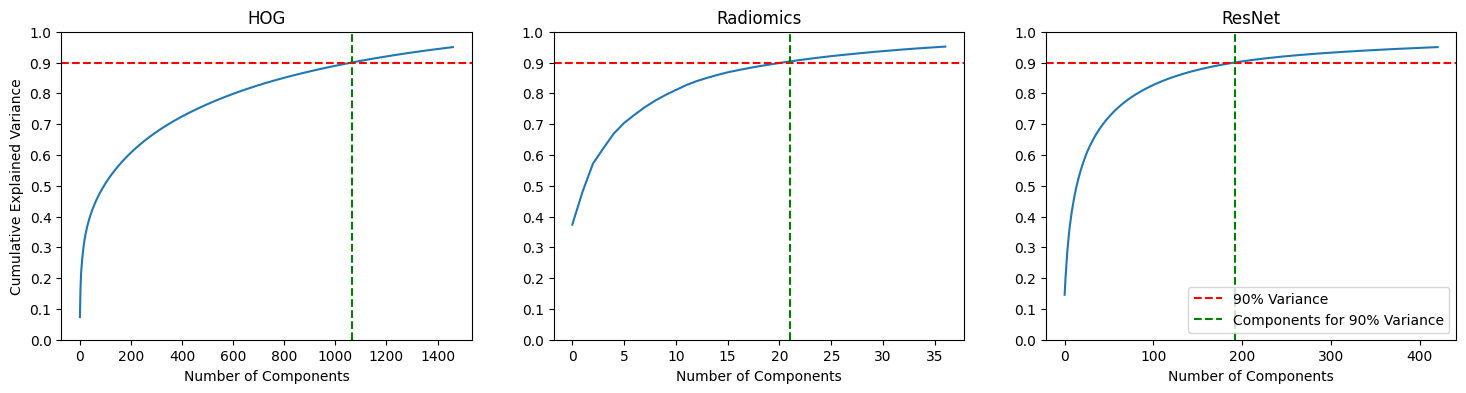

In [ ]:
# @title Vis: PCA Plots
def plot_PCA(pca_objects, feature_sets, var_target=0.9, export_path='reports/figures/PCA_plots.png'):
    """
    Plot the explained variance for PCA objects and mark the component count where the
    cumulative variance exceeds a target threshold.

    Args:
        pca_objects (list): List of PCA model objects.
        feature_sets (list): Corresponding labels for the PCA objects.
        var_target (float): Target cumulative variance threshold.
        export_path (str): Path where the plot will be saved.

    Returns:
        dict: A dictionary mapping feature sets to the number of components needed to exceed var_target.
    """
    if len(pca_objects) != len(feature_sets):
        raise ValueError("The length of pca_objects must match the length of feature_sets")

    component_indices = {}

    # Create a subplot for each PCA result
    fig, axes = plt.subplots(1, len(pca_objects), figsize=(6 * len(pca_objects), 4))
    if len(pca_objects) == 1:
        axes = [axes]  # Ensure axes is iterable for a single subplot case

    for i, (pca_obj, feature) in enumerate(zip(pca_objects, feature_sets)):
        # Calculate cumulative variance ratio
        explained_variance_ratio = pca_obj.explained_variance_ratio_
        cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

        # Find component index where cumulative variance exceeds the target
        component_count_90 = np.argmax(cumulative_variance_ratio >= var_target)
        component_indices[feature] = component_count_90 + 1  # Adjust for 0-index

        # Plotting
        axes[i].plot(cumulative_variance_ratio, linestyle='-')
        axes[i].set_title(f'{feature}')
        axes[i].set_xlabel('Number of Components')
        axes[i].set_ylim(0, 1)
        axes[i].axhline(y=var_target, color='red', linestyle='--', label=f'{var_target*100:.0f}% Variance')
        axes[i].axvline(x=component_count_90, color='green', linestyle='--', label=f'Components for {var_target*100:.0f}% Variance')

        # Enhancements
        axes[i].yaxis.set_major_locator(MultipleLocator(0.1))

        if i == 0:
            axes[i].set_ylabel('Cumulative Explained Variance')

        if i == 2:
            axes[i].legend(loc='lower right')

    # Save the plot if a path is provided
    if export_path:
        plt.savefig(export_path, bbox_inches='tight')

    plt.show()

    return component_indices

component_indices = plot_PCA([hog_pca_model, radiomics_pca_model, resnet_pca_model], ['HOG', 'Radiomics', 'ResNet'])

In [138]:
print("Number of components needed for 90% variance")
pprint(component_indices)

Number of components needed for 90% variance
{'HOG': 1065, 'Radiomics': 22, 'ResNet': 193}


### Apply to Test and Val Data

Shape of HOG_features: (13689,)
Shape of Radiomics_features: (241,)
Shape of Resnet_embeddings: (2048,)
Shape of all_features: (15978,)
Shape of HOG_features: (13689,)
Shape of Radiomics_features: (241,)
Shape of Resnet_embeddings: (2048,)
Shape of all_features: (15978,)


In [ ]:
def transform_val_test_data(df, column_name, scaler, pca, variance_thresholds):
    """
    Transform test data using the already fitted scaler and PCA for multiple variance thresholds.

    Args:
        df (pd.DataFrame): DataFrame containing the test data.
        column_name (str): Name of the column to be transformed.
        scaler (StandardScaler): Fitted scaler object.
        pca (PCA): Fitted PCA object.
        variance_thresholds (list of float): List of variance thresholds for data transformation.

    Returns:
        dict: Dictionary where keys are variance thresholds and values are the PCA-transformed test data.
    """
    data_matrix = np.vstack(df[column_name])
    data_scaled = scaler.transform(data_matrix)
    full_data_pca = pca.transform(data_scaled)

    results = {}
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
    for threshold in variance_thresholds:
        n_components_needed = np.argmax(cumulative_variance >= threshold) + 1
        results[threshold] = full_data_pca[:, :n_components_needed]

    return results

In [ ]:
hog_pca_data_test = transform_val_test_data(df_pca_test, 'hog_features', hog_pca_scaler, hog_pca_model, [0.9, 0.8, 0.7])
radiomics_pca_data_test = transform_val_test_data(df_pca_test, 'radiomics_features', radiomics_pca_scaler, radiomics_pca_model, [0.9, 0.8, 0.7])
resnet_pca_data_test = transform_val_test_data(df_pca_test, 'resnet_embeddings', resnet_pca_scaler, resnet_pca_model, [0.9, 0.8, 0.7])

In [ ]:
hog_pca_data_val = transform_val_test_data(df_pca_val, 'hog_features', hog_pca_scaler, hog_pca_model, [0.9, 0.8, 0.7])
radiomics_pca_data_val = transform_val_test_data(df_pca_val, 'radiomics_features', radiomics_pca_scaler, radiomics_pca_model, [0.9, 0.8, 0.7])
resnet_pca_data_val = transform_val_test_data(df_pca_val, 'resnet_embeddings', resnet_pca_scaler, resnet_pca_model, [0.9, 0.8, 0.7])

### Export as Pickle Files

In [ ]:
# @title Concatenate feature sets
X_train_PCA_90 = np.hstack([hog_pca_data_train[0.9], radiomics_pca_data_train[0.9], resnet_pca_data_train[0.9]])
X_test_PCA_90 = np.hstack([hog_pca_data_test[0.9], radiomics_pca_data_test[0.9], resnet_pca_data_test[0.9]])
X_val_PCA_90 = np.hstack([hog_pca_data_val[0.9], radiomics_pca_data_val[0.9], resnet_pca_data_val[0.9]])

print(f"Shape of X_train_PCA_90: {X_train_PCA_90.shape}")
print(f"Shape of X_test_PCA_90: {X_test_PCA_90.shape}")
print(f"Shape of X_val_PCA_90: {X_val_PCA_90.shape}")

assert X_train_PCA_90.shape[1] == X_test_PCA_90.shape[1] == X_val_PCA_90.shape[1]

X_train_PCA_80 = np.hstack([hog_pca_data_train[0.8], radiomics_pca_data_train[0.8], resnet_pca_data_train[0.8]])
X_test_PCA_80 = np.hstack([hog_pca_data_test[0.8], radiomics_pca_data_test[0.8], resnet_pca_data_test[0.8]])
X_val_PCA_80 = np.hstack([hog_pca_data_val[0.8], radiomics_pca_data_val[0.8], resnet_pca_data_val[0.8]])

print(f"Shape of X_train_PCA_80: {X_train_PCA_80.shape}")
print(f"Shape of X_test_PCA_80: {X_test_PCA_80.shape}")
print(f"Shape of X_val_PCA_80: {X_val_PCA_80.shape}")

assert X_train_PCA_80.shape[1] == X_test_PCA_80.shape[1] == X_val_PCA_80.shape[1]

X_train_PCA_70 = np.hstack([hog_pca_data_train[0.7], radiomics_pca_data_train[0.7], resnet_pca_data_train[0.7]])
X_test_PCA_70 = np.hstack([hog_pca_data_test[0.7], radiomics_pca_data_test[0.7], resnet_pca_data_test[0.7]])
X_val_PCA_70 = np.hstack([hog_pca_data_val[0.7], radiomics_pca_data_val[0.7], resnet_pca_data_val[0.7]])

print(f"Shape of X_train_PCA_70: {X_train_PCA_70.shape}")
print(f"Shape of X_test_PCA_70: {X_test_PCA_70.shape}")
print(f"Shape of X_val_PCA_70: {X_val_PCA_70.shape}")

assert X_train_PCA_70.shape[1] == X_test_PCA_70.shape[1] == X_val_PCA_70.shape[1]

y_train = df_pca_train['diag']
y_test = df_pca_test['diag']
y_val = df_pca_val['diag']

print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")
print(f"Shape of y_val: {y_val.shape}")

Shape of X_train_PCA_90: (20547, 1280)
Shape of X_test_PCA_90: (6420, 1280)
Shape of X_val_PCA_90: (5136, 1280)
Shape of X_train_PCA_80: (20547, 702)
Shape of X_test_PCA_80: (6420, 702)
Shape of X_val_PCA_80: (5136, 702)
Shape of X_train_PCA_70: (20547, 399)
Shape of X_test_PCA_70: (6420, 399)
Shape of X_val_PCA_70: (5136, 399)
Shape of y_train: (20547,)
Shape of y_test: (6420,)
Shape of y_val: (5136,)


In [ ]:
# @title Export
var_names = [
    X_train_PCA_90,
    X_train_PCA_80,
    X_train_PCA_70,
    X_test_PCA_90,
    X_test_PCA_80,
    X_test_PCA_70,
    X_val_PCA_90,
    X_val_PCA_80,
    X_val_PCA_70,
    y_train,
    y_train,
    y_train,
    y_test,
    y_test,
    y_test,
    y_val,
    y_val,
    y_val
]

file_names = [
    'X_train_feature_reduction_90.pickle',
    'X_train_feature_reduction_80.pickle',
    'X_train_feature_reduction_70.pickle',
    'X_test_feature_reduction_90.pickle',
    'X_test_feature_reduction_80.pickle',
    'X_test_feature_reduction_70.pickle',
    'X_val_feature_reduction_90.pickle',
    'X_val_feature_reduction_80.pickle',
    'X_val_feature_reduction_70.pickle',
    'y_train_90.pickle',
    'y_train_80.pickle',
    'y_train_70.pickle',
    'y_test_90.pickle',
    'y_test_80.pickle',
    'y_test_70.pickle',
    'y_val_90.pickle',
    'y_val_80.pickle',
    'y_val_70.pickle'
]

assert len(var_names) == len(file_names)

for var_name, file_name in zip(var_names, file_names):
    with open(os.path.join('data/features_PCA', file_name), 'wb') as f:
        pickle.dump(var_name, f)